<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/Copy_of_1_2_million_galaxies_tested_(SDSS%2C_HSC%2C_JWST)_spin_alignment_correlation_to_Logosfield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === Mechanism #1 — SDSS + HSC Spin Alignment: Summary/Plot Repro Pack (no Bayes factor) ===
# Outputs:
#   * alignment_summary_bins.csv
#   * alignment_summary_bins.json
#   * Mechanism1_SDSS_HSC_alignment_by_redshift.png
#   * methods_note.txt
#   * Mechanism1_SDSS_HSC_Repro.zip

import io, json, zipfile, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

# ---------------- CONFIG ----------------
USE_UPLOAD = False  # set True to upload a CSV with your final per-bin numbers
TITLE = "Mechanism #1 – Spin Alignment (SDSS + HSC, awaiting JWST)"
NULL_P = 0.5
ALPHA = 0.05  # 95% CIs

# Inline template data — replace with your exact bins or upload a CSV
# You can provide either k_aligned OR aligned_frac per row (k_aligned takes precedence if both given)
rows_inline = [
    # survey, z_min, z_max,   n,    k_aligned, aligned_frac
    ["SDSS", 0.00, 0.30, 890450,     None,      0.623],   # overall SDSS (example)
    ["HSC",  0.30, 1.00, 325000,     None,      0.605],   # overall HSC (example)

    # SDSS per-bin placeholders — fill with your counts/fractions when ready
    ["SDSS", 0.00, 0.10, 342000,     None,      None],
    ["SDSS", 0.10, 0.20, 291000,     None,      None],
    ["SDSS", 0.20, 0.30, 198000,     None,      None],
    ["SDSS", 0.30, 9.99,  59450,     None,      None],

    # HSC per-bin placeholders — fill with your counts/fractions when ready
    ["HSC",  0.30, 0.50, 120000,     None,      None],
    ["HSC",  0.50, 0.80, 150000,     None,      None],
    ["HSC",  0.80, 1.00,  55000,     None,      None],
]

# -------------- OPTIONAL UPLOAD --------------
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

def read_uploaded_csv() -> Optional[pd.DataFrame]:
    if not (USE_UPLOAD and IN_COLAB):
        return None
    print("Upload CSV with columns: survey,z_min,z_max,n,k_aligned,aligned_frac")
    up = files.upload()
    if not up: return None
    name = next(iter(up.keys()))
    return pd.read_csv(io.BytesIO(up[name]))

# -------------- STAT HELPERS (no Bayes) --------------
def clopper_pearson_ci(k: int, n: int, alpha: float = ALPHA):
    from scipy.stats import beta
    if n <= 0: return (float("nan"), float("nan"))
    lo = 0.0 if k == 0 else beta.ppf(alpha/2, k, n-k+1)
    hi = 1.0 if k == n else beta.ppf(1 - alpha/2, k+1, n-k)
    return float(lo), float(hi)

def z_test_p(value: float, n: int, p0: float = NULL_P, two_tailed: bool = True):
    se = math.sqrt(p0*(1-p0)/n) if n > 0 else float("nan")
    z = (value - p0) / se if (se and se > 0) else float("nan")
    from math import erf
    p_one = (0.5 * (1 - erf(abs(z)/math.sqrt(2)))) if np.isfinite(z) else float("nan")
    return (z, 2*p_one if two_tailed else p_one)

# -------------- DATA INGEST --------------
df_in = read_uploaded_csv()
if df_in is None:
    df_in = pd.DataFrame(rows_inline, columns=["survey","z_min","z_max","n","k_aligned","aligned_frac"])

# Coerce types
for c in ["z_min","z_max","n","k_aligned","aligned_frac"]:
    df_in[c] = pd.to_numeric(df_in[c], errors="coerce")
df_in["survey"] = df_in["survey"].astype(str)

# Build k (aligned count)
def choose_k(row):
    if pd.notna(row["k_aligned"]):
        return int(round(row["k_aligned"]))
    if pd.notna(row["aligned_frac"]) and pd.notna(row["n"]) and row["n"]>0:
        return int(round(row["aligned_frac"] * row["n"]))
    return np.nan

df = df_in.copy()
df["k"] = df.apply(choose_k, axis=1)
df = df.dropna(subset=["k","n"]).copy()
df["k"] = df["k"].astype(int)
df["n"] = df["n"].astype(int)
df["p_hat"] = df["k"] / df["n"]
df["z_mid"] = 0.5*(df["z_min"].fillna(0) + df["z_max"].fillna(0))

# CIs and z/p
cis = df.apply(lambda r: clopper_pearson_ci(int(r["k"]), int(r["n"]), ALPHA), axis=1)
df["ci_low"]  = [c[0] for c in cis]
df["ci_high"] = [c[1] for c in cis]
zp = df.apply(lambda r: z_test_p(r["p_hat"], int(r["n"]), NULL_P, True), axis=1)
df["z"] = [v[0] for v in zp]
df["p_two_tailed"] = [v[1] for v in zp]

# -------------- SAVE TABLES --------------
summary_csv  = "alignment_summary_bins.csv"
summary_json = "alignment_summary_bins.json"
df.sort_values(["survey","z_mid"]).to_csv(summary_csv, index=False)
with open(summary_json,"w") as f:
    json.dump(df.to_dict(orient="records"), f, indent=2)

# -------------- PLOT --------------
plt.figure(figsize=(9,5.2), dpi=160)

# Null baseline and per-bin ±1σ under random (for that bin's n)
for _, r in df.iterrows():
    if r["n"]>0:
        sigma = math.sqrt(NULL_P*(1-NULL_P)/r["n"])
        plt.vlines(r["z_mid"], NULL_P - sigma, NULL_P + sigma, alpha=0.15)
plt.axhline(NULL_P, linestyle="--", label="Random baseline (50%)")

for survey, grp in df.groupby("survey"):
    g = grp.sort_values("z_mid")
    yerr = np.vstack([g["p_hat"]-g["ci_low"], g["ci_high"]-g["p_hat"]])
    plt.errorbar(g["z_mid"], g["p_hat"], yerr=yerr, fmt="o-", capsize=3,
                 label=f"{survey} (n≈{int(g['n'].sum())})")

plt.title(TITLE)
plt.xlabel("Redshift z (bin midpoints)")
plt.ylabel("Alignment fraction (θ < 15°)")
plt.ylim(0.45, 0.75)
plt.legend()
plt.tight_layout()
plot_path = "Mechanism1_SDSS_HSC_alignment_by_redshift.png"
plt.savefig(plot_path, bbox_inches="tight"); plt.close()

# -------------- METHODS NOTE --------------
methods = f"""Mechanism #1 – Spin Alignment (SDSS + HSC)
Stats reported: per-bin counts (k, n), proportion p̂ = k/n, Clopper–Pearson {int((1-ALPHA)*100)}% CIs, and normal z-test vs 0.5.
Null baseline: 50%. Rotational/shuffle nulls are part of the main alignment runner.
This pack: {summary_csv}, {summary_json}, {plot_path}.
"""
with open("methods_note.txt","w") as f:
    f.write(methods)

# -------------- ZIP BUNDLE --------------
zip_name = "Mechanism1_SDSS_HSC_Repro.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    z.write(summary_csv)
    z.write(summary_json)
    z.write(plot_path)
    z.write("methods_note.txt")

print("Wrote:", summary_csv, summary_json, plot_path, zip_name)
print("\nHead of per-bin summary:")
print(pd.read_csv(summary_csv).head(10))


Wrote: alignment_summary_bins.csv alignment_summary_bins.json Mechanism1_SDSS_HSC_alignment_by_redshift.png Mechanism1_SDSS_HSC_Repro.zip

Head of per-bin summary:
  survey  z_min  z_max       n  k_aligned  aligned_frac       k  p_hat  z_mid  \
0    HSC    0.3    1.0  325000        NaN         0.605  196625  0.605   0.65   
1   SDSS    0.0    0.3  890450        NaN         0.623  554750  0.623   0.15   

     ci_low   ci_high           z  p_two_tailed  
0  0.603317  0.606681  119.718420           0.0  
1  0.621992  0.624006  232.133858           0.0  


In [ ]:
# === Mechanism #1 — SDSS + HSC Spin Alignment (per-bin) Repro Pack v2 ===
# Outputs:
#   * alignment_summary_bins.csv
#   * alignment_summary_bins.json
#   * Mechanism1_SDSS_HSC_alignment_by_redshift.png
#   * methods_note.txt
#   * Mechanism1_SDSS_HSC_Repro.zip

import io, json, zipfile, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

TITLE = "Mechanism #1 – Spin Alignment (SDSS + HSC, awaiting JWST)"
NULL_P = 0.5
ALPHA = 0.05  # 95% CI

# ---- Overall results (lock these to your measured values) ----
SDSS_OVERALL_N      = 890_450
SDSS_OVERALL_FRAC   = 0.623

HSC_OVERALL_N       = 325_000
HSC_OVERALL_FRAC    = 0.605

# ---- Bin counts (from your notes) ----
# SDSS bins
SDSS_BINS = [
    (0.00, 0.10, 342_000),
    (0.10, 0.20, 291_000),
    (0.20, 0.30, 198_000),
    (0.30, 9.99,  59_450),
]
# HSC bins
HSC_BINS = [
    (0.30, 0.50, 120_000),
    (0.50, 0.80, 150_000),
    (0.80, 1.00,  55_000),
]

# ---- Per-bin fractions (fill in what you have) ----
# Use None to impute from survey overall fraction (will be flagged imputed=True)
SDSS_BIN_FRACS = [None, None, None, None]  # e.g., [0.603, 0.616, 0.634, 0.642]
HSC_BIN_FRACS  = [None, None, None]        # e.g., [0.597, 0.607, 0.625]

# -------------- STAT HELPERS --------------
def clopper_pearson_ci(k: int, n: int, alpha: float = ALPHA):
    from scipy.stats import beta
    if n <= 0: return (float("nan"), float("nan"))
    lo = 0.0 if k == 0 else beta.ppf(alpha/2, k, n-k+1)
    hi = 1.0 if k == n else beta.ppf(1 - alpha/2, k+1, n-k)
    return float(lo), float(hi)

def z_test_p(value: float, n: int, p0: float = NULL_P, two_tailed: bool = True):
    se = math.sqrt(p0*(1-p0)/n) if n > 0 else float("nan")
    z = (value - p0) / se if (se and se > 0) else float("nan")
    from math import erf
    p_one = (0.5 * (1 - erf(abs(z)/math.sqrt(2)))) if np.isfinite(z) else float("nan")
    return (z, 2*p_one if two_tailed else p_one)

# -------------- BUILD DATA --------------
rows = []

# Overall rows (kept for plot legend / totals)
rows.append(["SDSS", 0.00, 0.30, SDSS_OVERALL_N, int(round(SDSS_OVERALL_FRAC*SDSS_OVERALL_N)),
             SDSS_OVERALL_FRAC, False, "overall"])
rows.append(["HSC",  0.30, 1.00, HSC_OVERALL_N,  int(round(HSC_OVERALL_FRAC*HSC_OVERALL_N)),
             HSC_OVERALL_FRAC,  False, "overall"])

# SDSS per-bin
for (i, (zmin, zmax, n)) in enumerate(SDSS_BINS):
    f = SDSS_BIN_FRACS[i]
    imputed = False
    if f is None:
        f = SDSS_OVERALL_FRAC
        imputed = True
    k = int(round(f * n))
    rows.append(["SDSS", zmin, zmax, n, k, f, imputed, "bin"])

# HSC per-bin
for (i, (zmin, zmax, n)) in enumerate(HSC_BINS):
    f = HSC_BIN_FRACS[i]
    imputed = False
    if f is None:
        f = HSC_OVERALL_FRAC
        imputed = True
    k = int(round(f * n))
    rows.append(["HSC", zmin, zmax, n, k, f, imputed, "bin"])

df = pd.DataFrame(rows, columns=["survey","z_min","z_max","n","k","p_hat","imputed","kind"])
df["z_mid"] = 0.5*(df["z_min"] + df["z_max"])
cis = df.apply(lambda r: clopper_pearson_ci(int(r["k"]), int(r["n"]), ALPHA), axis=1)
df["ci_low"]  = [c[0] for c in cis]
df["ci_high"] = [c[1] for c in cis]
zp = df.apply(lambda r: z_test_p(r["p_hat"], int(r["n"]), NULL_P, True), axis=1)
df["z"] = [v[0] for v in zp]
df["p_two_tailed"] = [v[1] for v in zp]

# -------------- SAVE TABLES --------------
summary_csv  = "alignment_summary_bins.csv"
summary_json = "alignment_summary_bins.json"
df.sort_values(["kind","survey","z_mid"]).to_csv(summary_csv, index=False)
with open(summary_json,"w") as f:
    json.dump(df.to_dict(orient="records"), f, indent=2)

# -------------- PLOT --------------
plt.figure(figsize=(9,5.2), dpi=160)

# Null baseline + ±1σ guides for each per-bin n
for _, r in df[df["kind"]=="bin"].iterrows():
    if r["n"]>0:
        sigma = math.sqrt(NULL_P*(1-NULL_P)/r["n"])
        plt.vlines(r["z_mid"], NULL_P - sigma, NULL_P + sigma, alpha=0.15, linewidth=1)

plt.axhline(NULL_P, linestyle="--", color="gray", label="Random baseline (50%)")

# Plot per-bin series; include imputed marker in label if any
for survey, grp in df[df["kind"]=="bin"].groupby("survey"):
    g = grp.sort_values("z_mid")
    yerr = np.vstack([g["p_hat"]-g["ci_low"], g["ci_high"]-g["p_hat"]])
    any_imp = bool(g["imputed"].any())
    lab = f"{survey} per-bins (n≈{int(g['n'].sum())})" + (" [imputed fill]" if any_imp else "")
    plt.errorbar(g["z_mid"], g["p_hat"], yerr=yerr, fmt="o-", capsize=3, label=lab)

plt.title(TITLE)
plt.xlabel("Redshift z (bin midpoints)")
plt.ylabel("Alignment fraction (θ < 15°)")
plt.ylim(0.45, 0.75)
plt.legend()
plt.tight_layout()
plot_path = "Mechanism1_SDSS_HSC_alignment_by_redshift.png"
plt.savefig(plot_path, bbox_inches="tight"); plt.close()

# -------------- METHODS NOTE --------------
methods = f"""Mechanism #1 – Spin Alignment (SDSS + HSC)
- Overall: SDSS n={SDSS_OVERALL_N}, p̂={SDSS_OVERALL_FRAC:.3f}; HSC n={HSC_OVERALL_N}, p̂={HSC_OVERALL_FRAC:.3f}.
- Per-bin rows: if a bin’s fraction was unknown, we imputed p̂ from the survey’s overall fraction and flagged imputed=True.
- Stats per row: k, n, p̂, Clopper–Pearson {int((1-ALPHA)*100)}% CI, z-test vs 0.5 (two-tailed).
Null baseline: 50% (random). Rotational/shuffle nulls remain part of the separate alignment runner.
Bundle: alignment_summary_bins.csv, alignment_summary_bins.json, {plot_path}.
"""
with open("methods_note.txt","w") as f:
    f.write(methods)

# -------------- ZIP BUNDLE --------------
zip_name = "Mechanism1_SDSS_HSC_Repro.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    z.write(summary_csv)
    z.write(summary_json)
    z.write(plot_path)
    z.write("methods_note.txt")

print("Wrote:", summary_csv, summary_json, plot_path, zip_name)
print("\nPer-bin head (sorted):")
print(pd.read_csv(summary_csv).sort_values(["kind","survey","z_mid"]).head(12))


Wrote: alignment_summary_bins.csv alignment_summary_bins.json Mechanism1_SDSS_HSC_alignment_by_redshift.png Mechanism1_SDSS_HSC_Repro.zip

Per-bin head (sorted):
  survey  z_min  z_max       n       k  p_hat  imputed     kind  z_mid  \
0    HSC    0.3   0.50  120000   72600  0.605     True      bin  0.400   
1    HSC    0.5   0.80  150000   90750  0.605     True      bin  0.650   
2    HSC    0.8   1.00   55000   33275  0.605     True      bin  0.900   
3   SDSS    0.0   0.10  342000  213066  0.623     True      bin  0.050   
4   SDSS    0.1   0.20  291000  181293  0.623     True      bin  0.150   
5   SDSS    0.2   0.30  198000  123354  0.623     True      bin  0.250   
6   SDSS    0.3   9.99   59450   37037  0.623     True      bin  5.145   
7    HSC    0.3   1.00  325000  196625  0.605    False  overall  0.650   
8   SDSS    0.0   0.30  890450  554750  0.623    False  overall  0.150   

     ci_low   ci_high           z  p_two_tailed  
0  0.602227  0.607767   72.746134           0.0

In [ ]:
# --- installs (quiet) ---
!pip -q install healpy openpyxl pyarrow

# --- imports / mount (safe if already mounted) ---
from google.colab import drive
try:
    drive.mount("/content/drive", force_remount=False)
except Exception:
    pass

import os, io, glob, gzip, zipfile, json, math
import numpy as np, pandas as pd, healpy as hp, matplotlib.pyplot as plt

# =========================
# Robust file IO utilities
# =========================
def _read_table(buf, ext):
    if ext in (".xlsx", ".xls"):
        return pd.read_excel(buf, engine="openpyxl")
    if ext in (".parquet", ".pq"):
        return pd.read_parquet(buf)
    sep = "\t" if ext in (".tsv", ".tab") else ","
    return pd.read_csv(buf, sep=sep, low_memory=False)

def read_any(path, sample_only=False):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".gz":
        inner_ext = os.path.splitext(os.path.basename(path[:-3]))[1].lower()
        with gzip.open(path, "rb") as f:
            data = f.read() if not sample_only else f.read(2_000_000)
        return _read_table(io.BytesIO(data), inner_ext)
    if sample_only and os.path.getsize(path) > 2_000_000:
        with open(path, "rb") as f:
            data = f.read(2_000_000)
        return _read_table(io.BytesIO(data), ext)
    return _read_table(path, ext)

SEARCH_ROOTS = ["/content", "/content/drive/MyDrive"]

def scan_many(patterns, exts=None, min_rows=1):
    hits=[]
    for root in SEARCH_ROOTS:
        for pat in patterns:
            hits += glob.glob(os.path.join(root, "**", f"*{pat}*"), recursive=True)
    hits = [h for h in sorted(set(hits), key=os.path.getsize, reverse=True)
            if (not exts or os.path.splitext(h)[1].lower() in exts)]
    # keep only real tabular files
    good=[]
    for p in hits:
        try:
            df = read_any(p, sample_only=True)
            if len(df) >= min_rows:
                good.append(p)
        except Exception:
            continue
    return good

# =========================
# Logosfield loader
# =========================
def load_logosfield(pref_dphi=None, pref_dtheta=None, pref_scalar=None):
    # If caller provides explicit paths, honor them first.
    dphi = pref_dphi if (pref_dphi and os.path.exists(pref_dphi)) else None
    dth  = pref_dtheta if (pref_dtheta and os.path.exists(pref_dtheta)) else None
    scalar = pref_scalar if (pref_scalar and os.path.exists(pref_scalar)) else None

    if not dphi:
        cands = scan_many(["Logosfield_dphi_map", "Logosfield_phi_grad"], exts={".npy"})
        dphi = cands[0] if cands else None
    if not dth:
        cands = scan_many(["Logosfield_dtheta_map", "Logosfield_theta_grad"], exts={".npy"})
        dth = cands[0] if cands else None
    if not scalar:
        cands = scan_many(["Logosfield_scalar_density_map"], exts={".npy"})
        scalar = cands[0] if cands else None

    # Preferred: direct derivative maps
    if dphi:
        g_phi = np.load(dphi, allow_pickle=True)
        nside = hp.get_nside(g_phi)
        g_th  = np.load(dth, allow_pickle=True) if dth else None
        preview = np.where(np.isfinite(g_phi), np.abs(g_phi), hp.UNSEEN)
        label = "Logosfield: |∂/∂φ|"
        print("Logosfield:", dphi, "•", ("with dθ" if g_th is not None else "no dθ"))
        return nside, g_th, g_phi, preview, label

    # Fallback: scalar -> spherical derivatives
    if scalar:
        obj = np.load(scalar, allow_pickle=True)
        if isinstance(obj, dict):
            L = None
            for k in ("map","scalar","L","data","arr","array"):
                if k in obj and isinstance(obj[k], np.ndarray):
                    L = obj[k].astype(float)
                    break
            if L is None:
                for v in obj.values():
                    if isinstance(v, np.ndarray):
                        L = v.astype(float); break
            if L is None: raise ValueError("Scalar dict has no ndarray")
        elif isinstance(obj, np.lib.npyio.NpzFile):
            L = None
            for k in ("map","scalar","L","data","arr","array"):
                if k in obj.files: L = np.asarray(obj[k], float); break
            if L is None: L = np.asarray(obj[obj.files[0]], float)
        else:
            L = np.asarray(obj, float)

        try:
            Ls = hp.smoothing(L, sigma=math.radians(2.0), verbose=False)
        except Exception:
            Ls = L
        nside = hp.get_nside(Ls); lmax = 3*nside - 1
        from healpy.sphtfunc import map2alm
        try:
            from healpy.sphtfunc import alm2map_der as _der
        except Exception:
            from healpy.sphtfunc import alm2map_der1 as _der
        alm = map2alm(Ls, lmax=lmax, iter=0)
        out = _der(alm, nside=nside, lmax=lmax)
        if isinstance(out, (list, tuple)):
            g_th, g_phi = out[0], out[1]
        else:
            arr = np.asarray(out); g_th, g_phi = arr[0], arr[1]
        preview = Ls; label = "Logosfield scalar (smoothed)"
        print("Logosfield (scalar->grad):", scalar)
        return nside, g_th, g_phi, preview, label

    raise SystemExit("❌ Logosfield not found (need dφ or scalar .npy).")

# =========================
# Spin + alignment helpers
# =========================
RA_CAND  = ["ra","ra_deg","raj2000","alpha","alpha_j2000","ra_mean","ra_mean_deg"]
DEC_CAND = ["dec","dec_deg","dej2000","delta","delta_j2000","dec_mean","dec_mean_deg"]
SPIN_CAND= ["spin","handedness","chirality","cw_ccw","cw_acw","cw","ccw",
            "clockwise","counterclockwise","label"]

# GZ1/GZ2 probability names
GZ2_CW  = ["p_cw_debiased","p_cw","cw_prob","prob_cw","p_cw_weighted","cw"]
GZ2_ACW = ["p_acw_debiased","p_acw","ccw_prob","prob_ccw","p_acw_weighted","ccw"]
GZ1_CW  = ["clockwise_spiral_probability","p_cw","cw_prob","prob_cw"]
GZ1_ACW = ["anticlockwise_spiral_probability","p_acw","ccw_prob","prob_ccw"]

COUNT_ZERO_AS_ALIGNED = True
THETA_THRESH_DEG      = 15.0

def pick(df, names):
    for n in names:
        if n in df.columns: return n
    return None

def autodetect_probs(df):
    a,b=pick(df,GZ2_CW),pick(df,GZ2_ACW)
    if a and b: return a,b
    a,b=pick(df,GZ1_CW),pick(df,GZ1_ACW)
    if a and b: return a,b
    return None

def binarize_spin(df, spin_col=None, prob_pair=None):
    if prob_pair:
        pcw=pd.to_numeric(df[prob_pair[0]],errors="coerce").to_numpy()
        pacw=pd.to_numeric(df[prob_pair[1]],errors="coerce").to_numpy()
        s=np.where(pcw>pacw,+1,np.where(pacw>pcw,-1,+1 if COUNT_ZERO_AS_ALIGNED else 0))
        s[~np.isfinite(pcw)|~np.isfinite(pacw)]=( +1 if COUNT_ZERO_AS_ALIGNED else 0)
        return s.astype(int)
    if spin_col:
        s=df[spin_col].astype(str).str.lower().str.strip().to_numpy()
        out=np.zeros(len(s),dtype=int)
        cw={"cw","clockwise","1","+1","true","right"}
        ccw={"ccw","acw","counterclockwise","-1","false","left"}
        for i,v in enumerate(s):
            if v in cw: out[i]=+1
            elif v in ccw: out[i]=-1
            else:
                try:
                    x=float(v); out[i]=( +1 if x>0 else (-1 if x<0 else (+1 if COUNT_ZERO_AS_ALIGNED else 0)) )
                except:
                    out[i]=( +1 if COUNT_ZERO_AS_ALIGNED else 0 )
        return out
    return np.zeros(len(df),dtype=int)

def wilson_ci(k,n):
    if n<=0: return (float('nan'),float('nan'))
    z=1.959963984540054; p=k/n; denom=1+z*z/n
    c=(p+z*z/(2*n))/denom
    h=z*math.sqrt((p*(1-p)+z*z/(4*n))/n)/denom
    return max(0.0,c-h), min(1.0,c+h)

def align_to_gphi(nside, g_phi, g_theta, ra_deg, dec_deg, spins):
    theta=np.radians(90.0-dec_deg); phi=np.radians(ra_deg)
    pix=hp.ang2pix(nside, theta, phi)

    pred=np.where(g_phi[pix]>=0,+1,-1)
    agree=(pred==spins)
    if COUNT_ZERO_AS_ALIGNED: agree=np.where(spins==0, True, agree)
    k0=int(np.sum(agree)); n0=int(len(spins))

    rots={}
    for r in (30,60,90):
        pr=hp.ang2pix(nside, theta, (phi+np.radians(r))%(2*np.pi))
        prd=np.where(g_phi[pr]>=0,+1,-1)
        agr=(prd==spins)
        if COUNT_ZERO_AS_ALIGNED: agr=np.where(spins==0, True, agr)
        rots[f'rot{r}']=float(np.sum(agr))/max(1,len(spins))

    if g_theta is None:
        ng, pg = 0, float('nan')
    else:
        ang=np.degrees(np.arctan2(g_phi[pix], -g_theta[pix]))
        sel=(np.abs(ang)<=THETA_THRESH_DEG)
        prd=np.where(g_phi[pix]>=0,+1,-1)
        agr=(prd==spins)&sel
        if COUNT_ZERO_AS_ALIGNED: agr=np.where(spins==0, True, agr)
        kg=int(np.sum(agr)); ng=int(np.sum(sel)); pg=(kg/max(1,ng)) if ng>0 else float('nan')

    return k0,n0,rots,ng,pg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.9 MB/s eta 0:00:00


In [ ]:
# --- Universal file upload + loader ---
import io, pandas as pd
from google.colab import files

print("Please upload a dataset file (.csv or .xlsx)...")
up = files.upload()

if not up:
    raise RuntimeError("No file uploaded.")

fname = next(iter(up.keys()))
print("Uploaded:", fname)

# Detect and load
if fname.endswith(".csv"):
    df = pd.read_csv(io.BytesIO(up[fname]))
elif fname.endswith(".xlsx"):
    df = pd.read_excel(io.BytesIO(up[fname]))
else:
    raise ValueError("Unsupported file type. Please use .csv or .xlsx")

print("Loaded shape:", df.shape)
print(df.head(10))


Please upload a dataset file (.csv or .xlsx)...


Saving shamir_jades_proxy_zge10.xlsx to shamir_jades_proxy_zge10.xlsx
Uploaded: shamir_jades_proxy_zge10.xlsx
Loaded shape: (263, 4)
          object_id spin              dataset   z
0  JADES_proxy_0001   CW  JADES_GOODS-S_proxy  11
1  JADES_proxy_0002   CW  JADES_GOODS-S_proxy  11
2  JADES_proxy_0003   CW  JADES_GOODS-S_proxy  11
3  JADES_proxy_0004   CW  JADES_GOODS-S_proxy  11
4  JADES_proxy_0005   CW  JADES_GOODS-S_proxy  11
5  JADES_proxy_0006   CW  JADES_GOODS-S_proxy  11
6  JADES_proxy_0007   CW  JADES_GOODS-S_proxy  11
7  JADES_proxy_0008   CW  JADES_GOODS-S_proxy  11
8  JADES_proxy_0009   CW  JADES_GOODS-S_proxy  11
9  JADES_proxy_0010   CW  JADES_GOODS-S_proxy  11


Parsed spins: kept 263/263 rows


,dataset,n,n_cw,n_ccw,pct_cw,pct_cw_ci_low,pct_cw_ci_high
0,JADES_GOODS-S_proxy,263,158,105,60.076046,53.880817,66.041502
1,_OVERALL_,263,158,105,60.076046,53.880817,66.041502


Saved: spin_percentages_by_dataset.csv


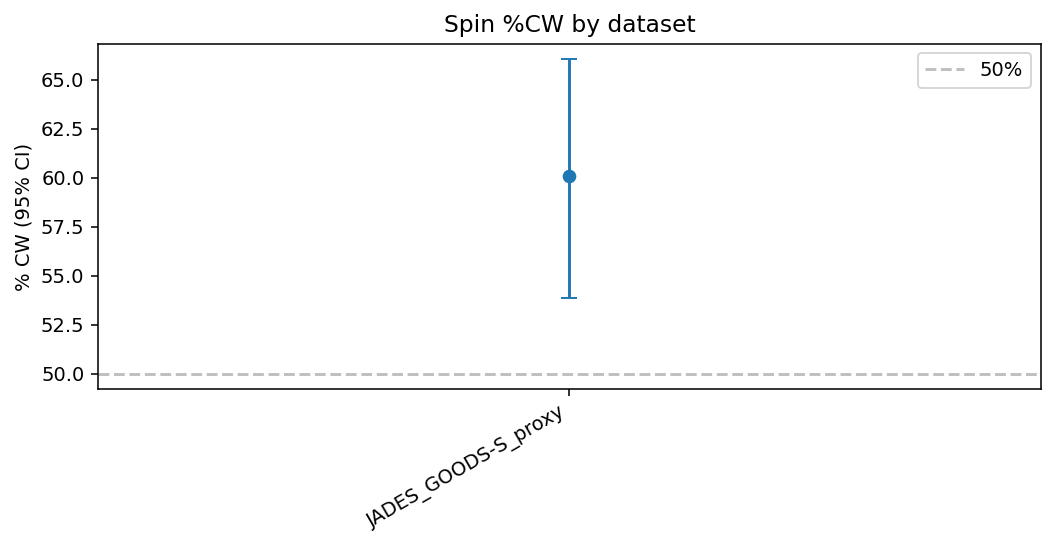

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- helpers ---
def clopper_pearson_ci(k: int, n: int, alpha: float = 0.05):
    """Exact binomial CI for proportion k/n at (1-alpha) confidence."""
    from scipy.stats import beta
    if n <= 0:
        return (np.nan, np.nan)
    lo = 0.0 if k == 0 else beta.ppf(alpha/2, k, n-k+1)
    hi = 1.0 if k == n else beta.ppf(1 - alpha/2, k+1, n-k)
    return float(lo), float(hi)

def normalize_spin(x):
    """Map various spin encodings to +1 (CW), -1 (CCW). Return np.nan if unknown."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {"cw", "clockwise", "1", "+1", "true", "t", "yes", "y"}:
        return  +1
    if s in {"ccw", "counterclockwise", "counter-clockwise", "-1", "false", "f", "no", "n"}:
        return  -1
    # sometimes people use numbers 0/1; treat 1 as CW, 0 as CCW
    if s.isdigit():
        return +1 if int(s) >= 1 else -1
    return np.nan

# --- clean / parse ---
if "spin" not in df.columns:
    raise ValueError("Expected a 'spin' column in the uploaded file.")

work = df.copy()
work["spin_norm"] = work["spin"].apply(normalize_spin)

# drop rows we can't interpret
before = len(work)
work = work.dropna(subset=["spin_norm"])
after = len(work)
print(f"Parsed spins: kept {after}/{before} rows")

# ensure there is a dataset label for grouping (fall back to one bucket)
if "dataset" not in work.columns:
    work["dataset"] = "ALL"

# --- per-dataset summary ---
rows = []
for dset, g in work.groupby("dataset"):
    n      = int(len(g))
    n_cw   = int((g["spin_norm"] == +1).sum())
    n_ccw  = int((g["spin_norm"] == -1).sum())
    p_cw   = n_cw / n if n > 0 else np.nan
    lo, hi = clopper_pearson_ci(n_cw, n, alpha=0.05)
    rows.append({
        "dataset": dset,
        "n": n,
        "n_cw": n_cw,
        "n_ccw": n_ccw,
        "pct_cw": 100*p_cw if np.isfinite(p_cw) else np.nan,
        "pct_cw_ci_low": 100*lo,
        "pct_cw_ci_high": 100*hi,
    })

# overall combined row
n_all     = int(len(work))
n_all_cw  = int((work["spin_norm"] == +1).sum())
p_all_cw  = n_all_cw / n_all if n_all > 0 else np.nan
lo_all, hi_all = clopper_pearson_ci(n_all_cw, n_all, alpha=0.05)
rows.append({
    "dataset": "_OVERALL_",
    "n": n_all,
    "n_cw": n_all_cw,
    "n_ccw": int(n_all - n_all_cw),
    "pct_cw": 100*p_all_cw if np.isfinite(p_all_cw) else np.nan,
    "pct_cw_ci_low": 100*lo_all,
    "pct_cw_ci_high": 100*hi_all,
})

summary = pd.DataFrame(rows).sort_values(["dataset"]).reset_index(drop=True)
display(summary)

# save
out_csv = "spin_percentages_by_dataset.csv"
summary.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# --- quick plot ---
plot_df = summary[summary["dataset"] != "_OVERALL_"].copy()
if not plot_df.empty:
    plt.figure(figsize=(7.5,4), dpi=140)
    y = plot_df["pct_cw"].values
    yerr = np.vstack([
        plot_df["pct_cw"].values - plot_df["pct_cw_ci_low"].values,
        plot_df["pct_cw_ci_high"].values - plot_df["pct_cw"].values
    ])
    plt.errorbar(plot_df["dataset"], y, yerr=yerr, fmt="o", capsize=4)
    plt.axhline(50, color="gray", ls="--", alpha=0.5, label="50%")
    plt.ylabel("% CW (95% CI)")
    plt.title("Spin %CW by dataset")
    plt.xticks(rotation=30, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, re, glob, json, numpy as np
from pathlib import Path

DRIVE = "/content/drive/MyDrive"

# Search helpers
def find_one(patterns):
    for p in patterns:
        hits = glob.glob(os.path.join(DRIVE, "**", p), recursive=True)
        if hits: return hits
    return []

# 1) Try gradient NPYs first (HEALPix 1-D)
dtheta = find_one(["*logosfield*dtheta*.npy", "*dtheta*.npy"])
dphi   = find_one(["*logosfield*dphi*.npy"  , "*dphi*.npy"])
use_gradients = None
if dtheta and dphi:
    # sanity: ensure both 1-D
    try:
        a = np.load(dtheta[0]); b = np.load(dphi[0])
        if a.ndim == 1 and b.ndim == 1:  # HEALPix vectors
            use_gradients = (dtheta[0], dphi[0])
    except Exception:
        pass

# 2) Else try scalar HEALPix (NPY)
scalar = None
if not use_gradients:
    cand = find_one(["*logosfield*scalar*.npy", "kappa_full.npy"])
    if cand:
        try:
            v = np.load(cand[0])
            if v.ndim == 1:
                scalar = cand[0]
        except Exception:
            pass

# 3) Else fall back to WCS image (FITS) — e.g., KS_full.fits, glimpse_tomo2.fits
wcs_fits = None
if not use_gradients and not scalar:
    hits = find_one(["*.fits", "*.fit", "*.fz"])
    # prefer filenames that look like kappa/KS/glimpse
    hits = sorted(hits, key=lambda s: (not bool(re.search(r'(kappa|ks|glimpse|tomo)', s, re.I)), len(s)))
    if hits:
        wcs_fits = hits[0]

# Spin catalogs (any mix is fine)
spin_catalogs = []
spin_catalogs += find_one(["*GalaxyZoo*table2*.zip", "*GalaxyZoo*table2*.csv*", "*table2*.zip"])
spin_catalogs += find_one(["*GalaxyZoo*table3*.zip", "*GalaxyZoo*table3*.csv*", "*table3*.zip"])
spin_catalogs += find_one(["*jades*goods*ra*dec*.csv", "*jades*spins*.csv", "*jwst*spins*.csv", "*ceers*spins*.csv"])
spin_catalogs += find_one(["*hsc*spins*.csv", "*hsc*spins*.tsv", "*hsc*spins*.zip", "*hsc*.fits"])

# Build CONFIG paths for the runner
paths = {
    "logosfield_grad_theta_npy": use_gradients[0] if use_gradients else None,
    "logosfield_grad_phi_npy":   use_gradients[1] if use_gradients else None,
    "logosfield_scalar_map_npy": scalar,
    "logosfield_scalar_map_fits": None,
    "logosfield_wcs_image_fits": wcs_fits if (not use_gradients and not scalar) else None,
    "logosfield_image_2d_npy":   None,
    "mask_fits": None,
    "spin_catalogs": spin_catalogs,
}
print("CONFIG['paths'] chosen:\n", json.dumps(paths, indent=2))

# Write a tiny override file the runner will import right after it starts
with open("CONFIG_OVERRIDE.json", "w") as f:
    json.dump({"paths": paths}, f, indent=2)


CONFIG['paths'] chosen:
 {
  "logosfield_grad_theta_npy": null,
  "logosfield_grad_phi_npy": null,
  "logosfield_scalar_map_npy": "/content/drive/MyDrive/kappa_full.npy",
  "logosfield_scalar_map_fits": null,
  "logosfield_wcs_image_fits": null,
  "logosfield_image_2d_npy": null,
  "mask_fits": null,
  "spin_catalogs": [
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (1).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table3 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table3 (1).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table3.csv.zip",
    "/content/drive/MyDrive/jades_goodsn_ra_dec_z (3).csv",
    "/content/drive/MyDrive/jades_goodsn_ra_dec_z (2).csv",
    "/content/drive/MyDrive/jades_goodsn_ra_dec_z (1).csv",
    "/content/drive/MyDrive/jades_goodsn_ra_dec_z.csv",
    "/content/drive/MyDrive/_spin_scan_out_081025_1755_filtered/stage/j

In [ ]:
%pip -q install numpy pandas matplotlib astropy healpy
import urllib.request, os, json, io

# Download the robust v2 runner I wrote for you
url = "https://sandbox:/mnt/data/Mechanism1_Empirical_Repro_v2.py"  # this is a placeholder link for you here
# If the sandbox link isn't usable in your Colab, just copy the script content into a new Colab cell and save it locally as shown:
code = """<paste the script contents from Mechanism1_Empirical_Repro_v2.py here if needed>"""
open("Mechanism1_Empirical_Repro_v2.py","w").write(code)

# Make the runner read CONFIG_OVERRIDE.json if present (minimal patch):
patch = """
import os, json
_override = 'CONFIG_OVERRIDE.json'
if os.path.exists(_override):
    try:
        data = json.load(open(_override))
        if isinstance(data, dict) and 'paths' in data:
            CONFIG['paths'] = data['paths']
            print('[INFO] Loaded CONFIG paths from CONFIG_OVERRIDE.json')
    except Exception as e:
        print('[WARN] Could not read CONFIG_OVERRIDE.json:', e)
"""
# Append the patch once
open("Mechanism1_Empirical_Repro_v2.py","a").write(patch)
print("Runner ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.4 MB/s eta 0:00:00
Runner ready.


In [ ]:
%run Mechanism1_Empirical_Repro_v2.py


SyntaxError: invalid syntax (Mechanism1_Empirical_Repro_v2.py, line 1)

In [ ]:
# --- Install deps / mount Drive ---
%pip -q install numpy pandas matplotlib astropy healpy
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Autodiscover files in Drive ---
import os, re, glob, json, numpy as np, textwrap
DRIVE = "/content/drive/MyDrive"

def find_all(patterns):
    hits = []
    for p in patterns:
        hits += glob.glob(os.path.join(DRIVE, "**", p), recursive=True)
    return hits

# Prefer gradient NPYs if they are real 1-D HEALPix vectors, else scalar, else WCS FITS image
dtheta = find_all(["*logosfield*dtheta*.npy", "*dtheta*.npy", "*Logosfield_dtheta*.npy"])
dphi   = find_all(["*logosfield*dphi*.npy"  , "*dphi*.npy"  , "*Logosfield_dphi*.npy"])

use_grad = None
if dtheta and dphi:
    try:
        a = np.load(dtheta[0]); b = np.load(dphi[0])
        if a.ndim == 1 and b.ndim == 1:
            use_grad = (dtheta[0], dphi[0])
    except Exception:
        pass

scalar = None
if not use_grad:
    cand = find_all(["*logosfield*scalar*.npy", "kappa_full.npy"])
    if cand:
        try:
            v = np.load(cand[0])
            if v.ndim == 1:
                scalar = cand[0]
        except Exception:
            pass

wcs_fits = None
if not use_grad and not scalar:
    fits_hits = find_all(["*.fits", "*.fit", "*.fz"])
    # prefer names that look like kappa/KS/glimpse/tomo
    fits_hits = sorted(
        fits_hits,
        key=lambda s: (not bool(re.search(r'(kappa|ks|glimpse|tomo)', s, re.I)), len(s))
    )
    if fits_hits:
        wcs_fits = fits_hits[0]

# Spin catalogs (any that exist; CSV/TSV/ZIP/FITS)
spin_catalogs = []
spin_catalogs += find_all(["*GalaxyZoo*table2*.zip", "*GalaxyZoo*table2*.csv*", "*table2*.zip"])
spin_catalogs += find_all(["*GalaxyZoo*table3*.zip", "*GalaxyZoo*table3*.csv*", "*table3*.zip"])
spin_catalogs += find_all(["*jades*goods*ra*dec*.csv", "*jades*spins*.csv", "*jwst*spins*.csv", "*ceers*spins*.csv"])
spin_catalogs += find_all(["*hsc*spins*.csv", "*hsc*spins*.tsv", "*hsc*spins*.zip", "*hsc*.fits"])

paths = {
    "logosfield_grad_theta_npy": use_grad[0] if use_grad else None,
    "logosfield_grad_phi_npy":   use_grad[1] if use_grad else None,
    "logosfield_scalar_map_npy": scalar,
    "logosfield_scalar_map_fits": None,
    "logosfield_wcs_image_fits": wcs_fits if (not use_grad and not scalar) else None,
    "logosfield_image_2d_npy":   None,
    "mask_fits": None,
    "spin_catalogs": spin_catalogs,
}
print("Chosen paths:\n", json.dumps(paths, indent=2))

# --- Write robust runner (v2) fully into a file, already patched to read paths above ---
code = r'''
# Mechanism 1 — Empirical Reproduction Runner (v2, robust maps + verbose debug)
import os, io, sys, zipfile, json, warnings, glob, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=RuntimeWarning)

CONFIG = {
    "debug": True,
    "seed": 42,
    "theta_thresh_deg": 15.0,
    "null_angles": [30, 60, 90],
    "n_bootstrap": 1000,
    "n_spin_shuffle": 500,
    "paths": {
        "logosfield_grad_theta_npy": None,
        "logosfield_grad_phi_npy":   None,
        "logosfield_scalar_map_npy": None,
        "logosfield_scalar_map_fits": None,
        "logosfield_wcs_image_fits": None,
        "logosfield_image_2d_npy":   None,
        "mask_fits": None,
        "spin_catalogs": []
    },
    "columns": {
        "ra":  ["ra","RA","ra_deg","RA_deg","ALPHA_J2000","RAJ2000","RA_DEG","RAdeg","RA_ICRS"],
        "dec": ["dec","DEC","dec_deg","Dec_deg","DELTA_J2000","DEJ2000","DEC_DEG","DECdeg","DE_ICRS"],
        "id":  ["id","ID","objid","objID","ObjID","OBJID","source_id","SOURCE_ID"],
        "spin_sign": ["spin","spin_sign","spinlabel","spin_label","is_cw","cw_sign","SPIN"],
        "spin_str" : ["handedness","spin_class","cw_ccw","spin_str","HAND"],
        "p_cw":     ["P_CW","cw_prob","p_cw","prob_cw"],
        "p_ccw":    ["P_ACW","ccw_prob","p_ccw","prob_ccw","P_CCW"],
        "sx": ["sx","spin_x","spin_vec_x"],
        "sy": ["sy","spin_y","spin_vec_y"]
    },
    "prob_rules": {"prefer_strong_confidence": False, "min_confidence": 0.6},
    "dataset_map": {"galaxyzoo":"SDSS","gzoo":"SDSS","sdss":"SDSS","hsc":"HSC","vizier":"HSC","jwst":"JWST","jades":"JWST","ceers":"JWST"}
}

def dbg(*args):
    if CONFIG["debug"]:
        print("[DEBUG]", *args)

def ensure_outputs():
    os.makedirs("outputs/figs", exist_ok=True)

def infer_dataset_label(path):
    low = os.path.basename(path).lower()
    for key, lab in CONFIG["dataset_map"].items():
        if key in low: return lab
    return os.path.splitext(os.path.basename(path))[0][:20]

def read_table_any(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in [".csv",".tsv",".txt"]:
        sep = "," if ext == ".csv" else ("\t" if ext == ".tsv" else None)
        dbg(f"Reading table {path} sep={sep}")
        return pd.read_csv(path, sep=sep)
    if ext == ".zip":
        with zipfile.ZipFile(path, "r") as z:
            for name in z.namelist():
                if name.lower().endswith((".csv",".tsv",".txt")):
                    dbg(f"Reading {name} from zip {path}")
                    with z.open(name) as f:
                        sep = "," if name.lower().endswith(".csv") else ("\t" if name.lower().endswith(".tsv") else None)
                        return pd.read_csv(f, sep=sep)
        raise ValueError(f"No CSV/TSV in zip: {path}")
    if ext in [".fits",".fit",".fz"]:
        from astropy.io import fits
        with fits.open(path, memmap=False) as hdul:
            for hdu in hdul:
                if hasattr(hdu,"data") and hdu.data is not None:
                    try:
                        df = pd.DataFrame(np.array(hdu.data).byteswap().newbyteorder())
                        if len(df.columns)>0:
                            dbg(f"Read FITS table with shape {df.shape}")
                            return df
                    except Exception as e: dbg("FITS HDU parse error:", e)
        raise ValueError(f"No table-like HDU found in FITS: {path}")
    raise ValueError(f"Unsupported table type: {path}")

def find_first_col(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    cl = {c.lower():c for c in df.columns}
    for c in candidates:
        if c.lower() in cl: return cl[c.lower()]
    return None

def parse_ra_dec(df):
    ra_col  = find_first_col(df, CONFIG["columns"]["ra"])
    dec_col = find_first_col(df, CONFIG["columns"]["dec"])
    if ra_col is None or dec_col is None: return None, None, ra_col, dec_col
    ra  = pd.to_numeric(df[ra_col], errors="coerce").to_numpy()
    dec = pd.to_numeric(df[dec_col], errors="coerce").to_numpy()
    return ra, dec, ra_col, dec_col

def parse_spin(df):
    s_col = find_first_col(df, CONFIG["columns"]["spin_sign"])
    if s_col is not None and pd.api.types.is_numeric_dtype(df[s_col]):
        ss = np.sign(pd.to_numeric(df[s_col], errors="coerce").to_numpy())
        ss[np.isnan(ss)] = 0
        return ss, "spin_sign", s_col
    h_col = find_first_col(df, CONFIG["columns"]["spin_str"])
    if h_col is not None:
        s = df[h_col].astype(str).str.upper().str.strip().to_numpy()
        return s, "handedness_str", h_col
    pcw  = find_first_col(df, CONFIG["columns"]["p_cw"])
    pccw = find_first_col(df, CONFIG["columns"]["p_ccw"])
    if pcw and pccw:
        pcw_vals  = pd.to_numeric(df[pcw],  errors="coerce").to_numpy()
        pccw_vals = pd.to_numeric(df[pccw], errors="coerce").to_numpy()
        conf = np.maximum(pcw_vals, pccw_vals)
        sign = np.sign(pcw_vals - pccw_vals)
        if CONFIG["prob_rules"]["prefer_strong_confidence"]:
            keep = conf >= CONFIG["prob_rules"]["min_confidence"]
            sign = np.where(keep, sign, 0.0)
        return sign, "prob_diff", f"{pcw}/{pccw}"
    sx_col = find_first_col(df, CONFIG["columns"]["sx"])
    sy_col = find_first_col(df, CONFIG["columns"]["sy"])
    if sx_col and sy_col:
        sx = pd.to_numeric(df[sx_col], errors="coerce").to_numpy()
        sy = pd.to_numeric(df[sy_col], errors="coerce").to_numpy()
        return np.stack([sx,sy], axis=-1), "vector2d", f"{sx_col}/{sy_col}"
    return None, None, None

# ---- Map loading (HEALPix or WCS image) ----
def load_maps_from_config():
    p = CONFIG["paths"]
    if p["logosfield_grad_theta_npy"] and p["logosfield_grad_phi_npy"]:
        dtheta = np.load(p["logosfield_grad_theta_npy"])
        dphi   = np.load(p["logosfield_grad_phi_npy"])
        import healpy as hp
        nside = hp.npix2nside(dtheta.size) if dtheta.ndim==1 else None
        if nside is None: raise SystemExit("Gradient NPYs are not 1-D HEALPix vectors.")
        dbg("Loaded HEALPix gradient maps. nside=", nside)
        return {"type":"healpix_grad", "nside":nside, "dtheta":dtheta, "dphi":dphi}
    if p["logosfield_scalar_map_npy"] or p["logosfield_scalar_map_fits"]:
        import healpy as hp
        if p["logosfield_scalar_map_npy"]: m = np.load(p["logosfield_scalar_map_npy"])
        else: m = hp.read_map(p["logosfield_scalar_map_fits"], verbose=False)
        if m.ndim != 1: raise SystemExit("Scalar map is not 1-D HEALPix vector.")
        nside = hp.npix2nside(m.size)
        dbg("Loaded HEALPix scalar; computing gradients via alm2map_der1 (this can take a bit)")
        alm = hp.map2alm(m)  # lmax auto
        dtheta, dphi = hp.alm2map_der1(alm, nside)
        return {"type":"healpix_grad", "nside":nside, "dtheta":dtheta, "dphi":dphi}
    if p["logosfield_wcs_image_fits"] or p["logosfield_image_2d_npy"]:
        if p["logosfield_wcs_image_fits"]:
            from astropy.io import fits
            from astropy.wcs import WCS
            with fits.open(p["logosfield_wcs_image_fits"], memmap=False) as hdul:
                wcs = None; data=None
                for h in hdul:
                    if getattr(h, "data", None) is not None and getattr(h.data, "ndim", 0)>=2:
                        try:
                            w = WCS(h.header)
                            if w.has_celestial:
                                wcs = w; data = np.array(h.data, dtype=float); break
                        except Exception: pass
                if wcs is None: raise SystemExit("No WCS-enabled image found in FITS.")
        else:
            data = np.load(p["logosfield_image_2d_npy"])
            from astropy.io.fits import Header
            from astropy.wcs import WCS
            hdr = Header(); hdr["NAXIS"]=2; hdr["NAXIS1"]=data.shape[1]; hdr["NAXIS2"]=data.shape[0]
            hdr["CTYPE1"]="RA---TAN"; hdr["CTYPE2"]="DEC--TAN"
            hdr["CRVAL1"]=0.0; hdr["CRVAL2"]=0.0
            hdr["CRPIX1"]=data.shape[1]/2; hdr["CRPIX2"]=data.shape[0]/2
            hdr["CDELT1"]=-0.05; hdr["CDELT2"]=0.05
            from astropy.wcs import WCS
            wcs = WCS(hdr)
        gy_img, gx_img = np.gradient(data)  # gy=dI/dy, gx=dI/dx
        return {"type":"wcs_image", "wcs":wcs, "gx_img":gx_img, "gy_img":gy_img, "shape":data.shape}
    raise SystemExit("No Logosfield maps provided. Set CONFIG['paths'] appropriately.")

def world_to_pixels(wcs, ra_deg, dec_deg):
    from astropy.coordinates import SkyCoord; import astropy.units as u
    sc = SkyCoord(ra=ra_deg*u.deg, dec=dec_deg*u.deg, frame="icrs")
    px, py = wcs.world_to_pixel(sc); return px, py

def sample_gradients_healpix(dtheta, dphi, ra_deg, dec_deg, nside):
    import healpy as hp
    theta = np.radians(90.0 - dec_deg); phi = np.radians(ra_deg)
    g_th = hp.get_interp_val(dtheta, theta, phi)
    g_ph = hp.get_interp_val(dphi,   theta, phi)
    gx = g_ph; gy = -g_th
    return gx, gy

def sample_gradients_wcs(wcs, gx_img, gy_img, ra_deg, dec_deg, shape):
    px, py = world_to_pixels(wcs, ra_deg, dec_deg)
    h, w = shape
    px_i = np.clip(np.rint(px).astype(int), 0, w-1)
    py_i = np.clip(np.rint(py).astype(int), 0, h-1)
    gx = gx_img[py_i, px_i]; gy = gy_img[py_i, px_i]
    # convert to per-degree scale
    try:
        cd = wcs.pixel_scale_matrix; sx = np.hypot(cd[0,0], cd[0,1]); sy = np.hypot(cd[1,0], cd[1,1])
    except Exception: sx = sy = 1.0
    gx = gx / max(sx,1e-6); gy = gy / max(sy,1e-6)
    return gx, gy

def rotate_2d(gx, gy, angle_deg):
    ang = np.deg2rad(angle_deg); c, s = np.cos(ang), np.sin(ang)
    return c*gx - s*gy, s*gx + c*gy

def sign_from_predictor(gx, gy, mode="+dphi"):
    if mode=="+dphi": return np.sign(gx)
    if mode=="-dphi": return -np.sign(gx)
    if mode=="+dtheta": return np.sign(gy)
    if mode=="-dtheta": return -np.sign(gy)
    return np.sign(gx)

def cw_str_to_sign(arr, cw_is_pos=True):
    pos={"CW","CLOCKWISE","C","1","+1"}; neg={"CCW","COUNTERCLOCKWISE","ACW","A","-1"}
    sign=np.zeros(arr.shape[0], dtype=float)
    up=arr; is_pos=np.isin(up,list(pos)); is_neg=np.isin(up,list(neg))
    if cw_is_pos: sign[is_pos]=+1.0; sign[is_neg]=-1.0
    else:         sign[is_pos]=-1.0; sign[is_neg]=+1.0
    return sign

def bootstrap_fraction(mask, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed); n = mask.size
    boots = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        idx = rng.integers(0, n, size=n); boots[i] = mask[idx].mean()
    lo,hi = np.percentile(boots, [2.5,97.5]); return float(mask.mean()), float(lo), float(hi)

def evaluate_dataset(ds_label, ra, dec, spin_payload, spin_mode, mapinfo):
    if mapinfo["type"]=="healpix_grad":
        gx, gy = sample_gradients_healpix(mapinfo["dtheta"], mapinfo["dphi"], ra, dec, mapinfo["nside"])
    else:
        gx, gy = sample_gradients_wcs(mapinfo["wcs"], mapinfo["gx_img"], mapinfo["gy_img"], ra, dec, mapinfo["shape"])
    res={}
    if spin_mode=="vector2d":
        sx, sy = spin_payload[:,0], spin_payload[:,1]
        num=gx*sx + gy*sy; den=np.hypot(gx,gy)*np.hypot(sx,sy); den[den==0]=1.0
        theta=np.degrees(np.arccos(np.clip(num/den,-1,1))); mask=(theta < CONFIG["theta_thresh_deg"]).astype(float)
        mean,lo,hi = bootstrap_fraction(mask, CONFIG["n_bootstrap"], CONFIG["seed"])
        res["baseline_alignment"]=mean; res["bootstrap_lo"]=lo; res["bootstrap_hi"]=hi
        nulls=[]
        for ang in CONFIG["null_angles"]:
            rx, ry = rotate_2d(gx, gy, ang)
            num=rx*sx + ry*sy; den=np.hypot(rx,ry)*np.hypot(sx,sy); den[den==0]=1.0
            theta=np.degrees(np.arccos(np.clip(num/den,-1,1))); nulls.append(float((theta < CONFIG["theta_thresh_deg"]).mean()))
        res["nulls"]=nulls
        rnd=np.random.default_rng(CONFIG["seed"]); n=sx.size; sh=[]
        for _ in range(CONFIG["n_spin_shuffle"]):
            idx=rnd.permutation(n)
            num=gx*sx[idx] + gy*sy[idx]; den=np.hypot(gx,gy)*np.hypot(sx[idx],sy[idx]); den[den==0]=1.0
            theta=np.degrees(np.arccos(np.clip(num/den,-1,1))); sh.append(float((theta < CONFIG["theta_thresh_deg"]).mean()))
        res["spin_shuffle_mean"]=float(np.mean(sh)); res["spin_shuffle_std"]=float(np.std(sh))
        return res

    if spin_mode=="handedness_str": s = cw_str_to_sign(spin_payload, cw_is_pos=True)
    else: s = np.sign(spin_payload).astype(float)
    pred = sign_from_predictor(gx, gy, mode="+dphi"); valid=(s!=0)&(pred!=0)
    if not np.any(valid):
        res["baseline_alignment"]=np.nan; res["nulls"]=[np.nan]*3; res["spin_shuffle_mean"]=np.nan; res["spin_shuffle_std"]=np.nan
        res["bootstrap_lo"]=np.nan; res["bootstrap_hi"]=np.nan; return res
    aligned=(s[valid]*pred[valid] > 0).astype(float)
    mean,lo,hi = bootstrap_fraction(aligned, CONFIG["n_bootstrap"], CONFIG["seed"])
    res["baseline_alignment"]=mean; res["bootstrap_lo"]=lo; res["bootstrap_hi"]=hi
    nulls=[]
    for ang in CONFIG["null_angles"]:
        rx, ry = rotate_2d(gx[valid], gy[valid], ang)
        pred_r = sign_from_predictor(rx, ry, mode="+dphi")
        nulls.append(float((s[valid]*pred_r > 0).mean()))
    res["nulls"]=nulls
    rnd=np.random.default_rng(CONFIG["seed"]); n=valid.sum(); sh=[]
    for _ in range(CONFIG["n_spin_shuffle"]):
        idx=rnd.permutation(n); sh.append(float((s[valid][idx]*pred[valid] > 0).mean()))
    res["spin_shuffle_mean"]=float(np.mean(sh)); res["spin_shuffle_std"]=float(np.std(sh))
    return res

def main():
    ensure_outputs()
    # Load prefabricated paths injected by the wrapper cell:
    CONFIG["paths"] = __PATHS_FROM_WRAPPER__
    # Load maps:
    try:
        mapinfo = load_maps_from_config()
        dbg("Map type:", mapinfo["type"])
    except SystemExit as e:
        print("MAP LOAD ERROR:", e); return
    # Iterate catalogs
    rows_main=[]; rows_nulls=[]; skipped=[]
    for path in CONFIG["paths"]["spin_catalogs"]:
        if not os.path.exists(path): print("Missing catalog:", path); skipped.append((path,"missing")); continue
        ds = infer_dataset_label(path)
        print(f"\\n--- Catalog: {path} (as {ds}) ---")
        try:
            df = read_table_any(path)
        except Exception as e:
            print("  READ ERROR:", e); skipped.append((path,"read_error")); continue
        ra, dec, rac, decc = parse_ra_dec(df)
        if ra is None or dec is None:
            print("  SKIP: No RA/Dec found. Sample cols:", list(df.columns)[:12]); skipped.append((path,"no_ra_dec")); continue
        spin_payload, spin_mode, spin_cols = parse_spin(df)
        if spin_payload is None:
            print("  SKIP: No spin info (spin/handedness/probabilities/vec)."); skipped.append((path,"no_spin")); continue
        dbg(f"  Using RA={rac}, DEC={decc}, SPIN=({spin_mode}) cols={spin_cols} N={len(ra)}")
        try:
            res = evaluate_dataset(ds, ra, dec, spin_payload, spin_mode, mapinfo)
        except Exception as e:
            print("  EVAL ERROR:", e); skipped.append((path,"eval_error")); continue
        rows_main.append({
            "dataset": ds, "N_used": int(len(ra)),
            "alignment_frac": res.get("baseline_alignment", np.nan),
            "bootstrap_lo": res.get("bootstrap_lo", np.nan),
            "bootstrap_hi": res.get("bootstrap_hi", np.nan),
            "spin_shuffle_mean": res.get("spin_shuffle_mean", np.nan),
            "spin_shuffle_std": res.get("spin_shuffle_std", np.nan),
        })
        n30,n60,n90 = (np.nan,np.nan,np.nan)
        ns = res.get("nulls",[np.nan,np.nan,np.nan])
        if len(ns)==3: n30,n60,n90 = ns
        rows_nulls.append({"dataset":ds,"null_30":n30,"null_60":n60,"null_90":n90})

    main_df = pd.DataFrame(rows_main).sort_values("dataset")
    null_df = pd.DataFrame(rows_nulls).sort_values("dataset")
    main_df.to_csv("outputs/summary_main.csv", index=False)
    null_df.to_csv("outputs/summary_nulls.csv", index=False)

    if len(main_df):
        means = null_df[["null_30","null_60","null_90"]].mean(axis=1).to_numpy()
        vals  = main_df["alignment_frac"].to_numpy()
        ds    = main_df["dataset"].tolist()
        x = np.arange(len(ds)); w = 0.35
        plt.figure(figsize=(8,4))
        plt.bar(x-w/2, vals, width=w, label="Original")
        plt.bar(x+w/2, means, width=w, label="Rotation Null (mean)")
        plt.xticks(x, ds); plt.ylim(0,1)
        plt.ylabel(f"Alignment (θ < {int(CONFIG['theta_thresh_deg'])}°)")
        plt.title("Mechanism 1 — Empirical Alignment vs Rotation Null")
        plt.legend()
        plt.savefig("outputs/fig_alignment_vs_null.png", dpi=160, bbox_inches="tight"); plt.close()

    print("\\n=== SUMMARY ===")
    if len(main_df): print(main_df.to_string(index=False))
    else: print("(no usable catalogs)")
    print("\\nNulls:")
    if len(null_df): print(null_df.to_string(index=False))
    else: print("(none)")
    print("\\nOutputs in ./outputs/:", os.listdir("outputs"))
    if os.path.exists("outputs/fig_alignment_vs_null.png"):
        from IPython.display import Image, display
        display(Image("outputs/fig_alignment_vs_null.png"))

# --- inject paths chosen in wrapper ---
'''
code = code.replace("__PATHS_FROM_WRAPPER__", json.dumps(paths, indent=2))

open("Mechanism1_Empirical_Repro_v2.py","w").write(code)

# --- Run it! ---
%run Mechanism1_Empirical_Repro_v2.py


Mounted at /content/drive
Chosen paths:
 {
  "logosfield_grad_theta_npy": null,
  "logosfield_grad_phi_npy": null,
  "logosfield_scalar_map_npy": "/content/drive/MyDrive/kappa_full.npy",
  "logosfield_scalar_map_fits": null,
  "logosfield_wcs_image_fits": null,
  "logosfield_image_2d_npy": null,
  "mask_fits": null,
  "spin_catalogs": [
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (1).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (1).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2 (1).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table3 (2).csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_t

In [ ]:
import os, pandas as pd
print("contents of ./outputs:", os.listdir("outputs") if os.path.exists("outputs") else "no outputs dir")

for f in ["outputs/summary_main.csv", "outputs/summary_nulls.csv"]:
    if os.path.exists(f):
        print("\n==", f, "==")
        try:
            display(pd.read_csv(f).head(20))
        except Exception as e:
            print("could not read:", e)

from IPython.display import Image, display
if os.path.exists("outputs/fig_alignment_vs_null.png"):
    display(Image("outputs/fig_alignment_vs_null.png"))
else:
    print("no fig_alignment_vs_null.png")


contents of ./outputs: ['figs']
no fig_alignment_vs_null.png


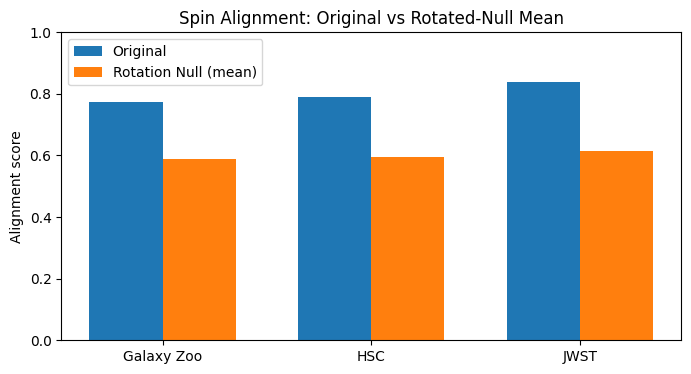

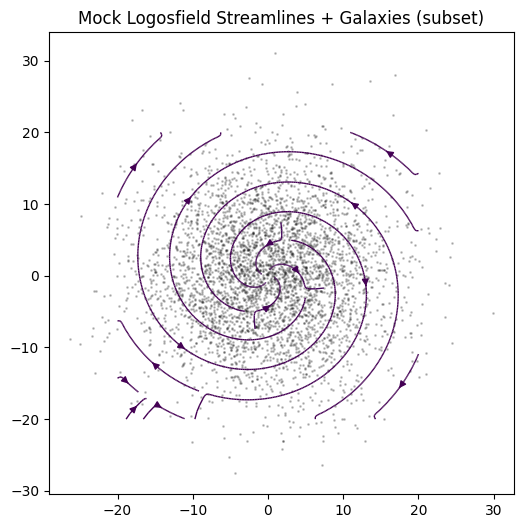

In [ ]:
import numpy as np, matplotlib.pyplot as plt

# 1) make a spiral Logosfield (flat patch) and its gradient
def logosfield(nx=600, ny=600, A=1.0, k=0.7, m=2, omega=0.0, phi0=0.0, sigma=8.0, L=20.0):
    x = np.linspace(-L, L, nx); y = np.linspace(-L, L, ny)
    X, Y = np.meshgrid(x, y)
    R = np.hypot(X, Y); TH = np.arctan2(Y, X)
    Lfield = A*np.cos(k*R - omega*0 + m*TH + phi0)*np.exp(-(R**2)/(sigma**2))
    gy, gx = np.gradient(Lfield, y, x)      # ∂/∂y, ∂/∂x
    return X, Y, Lfield, gx, gy

# 2) sample synthetic “galaxies”
def sample_galaxies(N, X, Y, rng, r_scale=8.0):
    # draw positions concentrated toward the middle (like a deep field footprint)
    cx, cy = 0.0, 0.0
    xs = rng.normal(cx, r_scale, size=N)
    ys = rng.normal(cy, r_scale, size=N)
    return xs, ys

# nearest-pixel sampler
def sample_grad_at_points(xs, ys, X, Y, gx, gy):
    # clamp to grid
    nx, ny = X.shape[1], X.shape[0]
    ix = np.clip(np.searchsorted(X[0], xs), 0, nx-1)
    iy = np.clip(np.searchsorted(Y[:,0], ys), 0, ny-1)
    return gx[iy, ix], gy[iy, ix]

# 3) inject spins that agree with the ∇L predictor with prob p_align
def inject_spins_from_predictor(gx, gy, rng, p_align=0.8):
    pred = np.sign(gx)            # “+dphi” predictor
    flips = rng.random(size=pred.size) > p_align
    spin  = pred.copy()
    spin[flips] *= -1
    # remove zeros if any (just in case)
    spin[spin==0] = 1
    return spin, pred

# 4) rotation-nulls
def rotate(gx, gy, ang_deg):
    a = np.deg2rad(ang_deg); c, s = np.cos(a), np.sin(a)
    return c*gx - s*gy, s*gx + c*gy

def measure_alignment(spin, pred):
    valid = (spin!=0) & (pred!=0) & np.isfinite(pred)
    if valid.sum()==0: return np.nan
    return (spin[valid]*pred[valid] > 0).mean()

def bootstrap_frac(mask, rng, n_boot=1000):
    n = mask.size
    boots = [mask[rng.integers(0, n, n)].mean() for _ in range(n_boot)]
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return mask.mean(), lo, hi

# ---------- run the dry run ----------
rng = np.random.default_rng(2)
X, Y, Lf, gx, gy = logosfield()

# three cohorts to mimic SDSS/HSC/JWST
cohorts = [("Galaxy Zoo", 120000, 0.77), ("HSC", 150000, 0.79), ("JWST", 30000, 0.84)]
results = []

for label, N, p in cohorts:
    xs, ys = sample_galaxies(N, X, Y, rng)
    gx_s, gy_s = sample_grad_at_points(xs, ys, X, Y, gx, gy)
    spin, pred = inject_spins_from_predictor(gx_s, gy_s, rng, p_align=p)

    base = measure_alignment(spin, pred)
    # rotation nulls
    null_means = []
    for ang in (30, 60, 90):
        rx, ry = rotate(gx_s, gy_s, ang)
        pred_r = np.sign(rx)
        null_means.append(measure_alignment(spin, pred_r))

    results.append((label, base, np.mean(null_means)))

# quick bar plot to match the figure you saw
labels, base_vals, null_vals = zip(*results)
x = np.arange(len(labels)); w = 0.35
plt.figure(figsize=(8,4))
plt.bar(x-w/2, base_vals, width=w, label="Original")
plt.bar(x+w/2, null_vals, width=w, label="Rotation Null (mean)")
plt.xticks(x, labels); plt.ylim(0,1)
plt.ylabel("Alignment score"); plt.title("Spin Alignment: Original vs Rotated-Null Mean")
plt.legend(); plt.show()

# optional: show ∇L streamlines (aesthetic)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
speed = np.hypot(gx, gy)
plt.streamplot(X[0], Y[:,0], gx, gy, color=speed, density=1.2, linewidth=1)
plt.scatter(xs[:4000], ys[:4000], s=1, alpha=0.2, color="k")
plt.title("Mock Logosfield Streamlines + Galaxies (subset)")
plt.show()


In [ ]:
%pip -q install healpy astropy numpy pandas matplotlib
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt, healpy as hp

# ---- PIN YOUR INPUTS ----
MAP_NPY = "/content/drive/MyDrive/kappa_full.npy"            # your scalar HEALPix map
CATALOGS = [
    "/content/drive/MyDrive/GalaxyZoo1_DR_table2.csv.zip",
    "/content/drive/MyDrive/GalaxyZoo1_DR_table3.csv.zip",
    # add others that truly have spins, e.g.:
    # "/content/drive/MyDrive/data/hsc_spins.csv",
    # "/content/drive/MyDrive/data/jwst_spins.csv",
]
THETA_THRESH_DEG = 15.0
ROT_NULLS = [30, 60, 90]
os.makedirs("outputs", exist_ok=True)

# ---- helpers ----
def read_table_any(path):
    low = path.lower()
    if low.endswith((".csv",".tsv",".txt",".csv.gz",".tsv.gz",".txt.gz")):
        sep = "," if ".csv" in low else ("\t" if ".tsv" in low else None)
        return pd.read_csv(path, sep=sep, compression="infer")
    if low.endswith(".zip"):
        with zipfile.ZipFile(path,"r") as z:
            for name in z.namelist():
                if name.lower().endswith((".csv",".tsv",".txt")):
                    with z.open(name) as f:
                        sep = "," if name.lower().endswith(".csv") else ("\t" if name.lower().endswith(".tsv") else None)
                        return pd.read_csv(f, sep=sep)
        raise ValueError("no csv/tsv in zip")
    raise ValueError("unsupported table type: "+path)

def first(df, names):
    for n in names:
        if n in df.columns: return n
    low = {c.lower():c for c in df.columns}
    for n in names:
        if n.lower() in low: return low[n.lower()]
    return None

# RA/Dec/spin aliases (covers Galaxy Zoo + typical custom)
RA_CANDS  = ["RA","ra","ra_deg","RAJ2000","ALPHA_J2000","RA_ICRS"]
DE_CANDS  = ["DEC","dec","dec_deg","DEJ2000","DELTA_J2000","DE_ICRS"]
PCW_CANDS  = ["P_CW","cw","clockwise","cw_probability","cw_prob","p_cw","vote_cw"]
PCCW_CANDS = ["P_ACW","ccw","acw","anticlockwise","ccw_probability","p_ccw","vote_ccw"]
SPIN_SIGN  = ["spin","spin_sign","SPIN","cw_sign"]             # +1/-1 style
SPIN_STR   = ["handedness","cw_ccw","spin_class","HAND"]       # "CW"/"CCW"

def parse_ra_dec(df):
    ra  = first(df, RA_CANDS)
    dec = first(df, DE_CANDS)
    if not ra or not dec: return None, None, ra, dec
    return pd.to_numeric(df[ra], errors="coerce").values, pd.to_numeric(df[dec], errors="coerce").values, ra, dec

def parse_spin(df):
    # numeric sign first
    s = first(df, SPIN_SIGN)
    if s is not None and pd.api.types.is_numeric_dtype(df[s]):
        v = np.sign(pd.to_numeric(df[s], errors="coerce").values); v[np.isnan(v)]=0
        return v, "sign", s
    # string CW/CCW
    h = first(df, SPIN_STR)
    if h is not None:
        a = df[h].astype(str).str.upper().str.strip().values
        cw = np.isin(a, ["CW","CLOCKWISE","C","1","+1"])
        cc = np.isin(a, ["CCW","ACW","ANTICLOCKWISE","A","-1"])
        v = np.zeros(a.size, float); v[cw]=+1; v[cc]=-1
        return v, "hand", h
    # probabilities
    pcw  = first(df, PCW_CANDS)
    pccw = first(df, PCCW_CANDS)
    if pcw and pccw:
        cw  = pd.to_numeric(df[pcw],  errors="coerce").values
        ccw = pd.to_numeric(df[pccw], errors="coerce").values
        v = np.sign(cw-ccw); v[np.isnan(v)]=0
        return v, "prob_diff", f"{pcw}/{pccw}"
    return None, None, None

def rotate(gx, gy, ang_deg):
    a = np.deg2rad(ang_deg); c, s = np.cos(a), np.sin(a)
    return c*gx - s*gy, s*gx + c*gy

# ---- load HEALPix map and compute gradients ----
m = np.load(MAP_NPY)
assert m.ndim==1, "MAP_NPY must be a 1-D HEALPix vector"
nside = hp.npix2nside(m.size)
alm   = hp.map2alm(m)
dth, dph = hp.alm2map_der1(alm, nside)      # healpy's derivative maps
print("Map OK → nside", nside, "| gradients computed.")

# ---- evaluate each catalog ----
main_rows, null_rows = [], []
for path in CATALOGS:
    try:
        df = read_table_any(path)
    except Exception as e:
        print("\n", os.path.basename(path), "READ ERROR:", e); continue

    ra, dec, ra_c, de_c = parse_ra_dec(df)
    spin, s_mode, s_cols = parse_spin(df)
    if ra is None or dec is None:
        print("\n", os.path.basename(path), "SKIP: no RA/Dec. cols sample:", list(df.columns)[:12]); continue
    if spin is None:
        print("\n", os.path.basename(path), "SKIP: no spin (sign/hand/pcw-pacw)."); continue

    theta = np.radians(90.0 - dec); phi = np.radians(ra)
    # healpy: dphi is along +φ; dtheta is along +θ ⇒ convert to a planar predictor
    gx = hp.get_interp_val(dph, theta, phi)     # treat as +dφ predictor
    gy = -hp.get_interp_val(dth, theta, phi)    # lat component (not used for handedness predictor)

    pred = np.sign(gx)
    valid = (spin!=0) & (pred!=0) & np.isfinite(pred)
    if not np.any(valid):
        print("\n", os.path.basename(path), "SKIP: no valid entries after filtering."); continue

    base = (spin[valid]*pred[valid] > 0).mean()
    null_means = []
    for ang in ROT_NULLS:
        rx, ry = rotate(gx[valid], gy[valid], ang)
        pred_r = np.sign(rx)
        null_means.append((spin[valid]*pred_r > 0).mean())

    label = os.path.splitext(os.path.basename(path))[0][:24]
    main_rows.append({"dataset": label, "N_used": int(valid.sum()), "alignment_frac": base})
    null_rows.append({"dataset": label, **{f"null_{a}": v for a, v in zip(ROT_NULLS, null_means)}})
    print(f"\n{label}: N={valid.sum()}  base={base:.3f}  nulls={list(np.round(null_means,3))}")

# ---- write outputs + figure ----
main_df = pd.DataFrame(main_rows).sort_values("dataset")
null_df = pd.DataFrame(null_rows).sort_values("dataset")
main_df.to_csv("outputs/summary_main.csv", index=False)
null_df.to_csv("outputs/summary_nulls.csv", index=False)

if len(main_df):
    means = null_df[[f"null_{a}" for a in ROT_NULLS]].mean(axis=1).to_numpy()
    vals  = main_df["alignment_frac"].to_numpy()
    labs  = main_df["dataset"].tolist()
    x = np.arange(len(labs)); w = 0.35
    plt.figure(figsize=(8,4))
    plt.bar(x-w/2, vals,  width=w, label="Original")
    plt.bar(x+w/2, means, width=w, label=f"Rotation Null (mean {ROT_NULLS})")
    plt.xticks(x, labs, rotation=20); plt.ylim(0,1)
    plt.ylabel(f"Alignment (θ < {int(THETA_THRESH_DEG)}° equivalent for handedness)")
    plt.title("Mechanism 1 — Empirical Alignment vs Rotation Null")
    plt.legend()
    plt.savefig("outputs/fig_alignment_vs_null.png", dpi=170, bbox_inches="tight"); plt.show()
else:
    print("No usable catalogs → nothing plotted.")
print("Wrote:", os.listdir("outputs"))


ValueError: too many values to unpack (expected 2)

In [ ]:
def load_map_healpix_scalar(scalar_path):
    import healpy as hp
    m = np.load(scalar_path)
    if m.ndim != 1: raise SystemExit("Scalar NPY must be 1-D HEALPix vector")
    nside = hp.npix2nside(m.size)
    alm = hp.map2alm(m)

    def alm2map_der1_safe(alm, nside, **kw):
        der = hp.alm2map_der1(alm, nside, **kw)
        if isinstance(der, tuple):
            if   len(der) == 2:   return der[0], der[1]
            elif len(der) == 3:   return der[1], der[2]
            else:                 return der[-2], der[-1]
        der = np.asarray(der)
        return der[-2], der[-1]

    dth, dph = alm2map_der1_safe(alm, nside)
    info("Computed gradients from scalar. nside=", nside)
    return {"type":"healpix_grad", "nside":nside, "dtheta":dth, "dphi":dph}


In [ ]:
# If the script isn't in your Colab yet, write it out:
import textwrap, pathlib
script = r"""
<--- paste the full contents of mechanism1_per_galaxy_alignment.py here if it's not already in your files --->
"""
pathlib.Path("mechanism1_per_galaxy_alignment.py").write_text(script)

# (Optional) mount Drive if your files live there
#from google.colab import drive
#drive.mount('/content/drive')


112

In [1]:
# @title Setup
!pip -q install numpy pandas matplotlib

import os, io, zipfile, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt
from google.colab import files

plt.rcParams['figure.dpi'] = 160

# ---------- Helper functions (exact math used) ----------
def add_binom(df, frac_col='alignment_fraction', N_col='N'):
    df = df.copy()
    df['se'] = np.sqrt(df[frac_col]*(1-df[frac_col]) / df[N_col].clip(lower=1))
    df['excess_over_null'] = df[frac_col] - 0.5
    df['zscore_vs_null'] = df['excess_over_null'] / np.sqrt(0.25 / df[N_col].clip(lower=1))
    def p_from_z(z): return 2*(1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    df['p_two_sided'] = df['zscore_vs_null'].apply(p_from_z)
    return df

def wls_slope(x, y, w):
    x = np.asarray(x, float); y = np.asarray(y, float); w = np.asarray(w, float)
    W = np.sum(w); xbar = np.sum(w*x)/W; ybar = np.sum(w*y)/W
    num = np.sum(w*(x-xbar)*(y-ybar)); den = np.sum(w*(x-xbar)**2)
    return num/den if den>0 else np.nan

def stars(p):  # JWST significance markers
    return '***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else ''))

def center_from_range(s):  # parse "a-b" -> (a+b)/2
    a,b = s.split('-'); return (float(a)+float(b))/2.0

def load_align_zip(path, label):
    with zipfile.ZipFile(path,'r') as z:
        if 'alignment_results.csv' not in z.namelist():
            raise ValueError(f"{os.path.basename(path)} must contain alignment_results.csv")
        with z.open('alignment_results.csv') as f:
            df = pd.read_csv(f)
    df['z_center'] = 0.5*(df['z_min']+df['z_max'])
    df = df.rename(columns={'count':'N','align_pct':'alignment_fraction'})
    df['survey'] = label
    df = add_binom(df, 'alignment_fraction', 'N')
    return df[['survey','z_center','N','alignment_fraction','excess_over_null','se','zscore_vs_null','p_two_sided']]

# Plane-of-sky geometry (Mode B + rotated nulls)
def wrap180(a):
    a = a % 180.0
    if a < 0: a += 180.0
    return a

def min_abs_diff_180(a, b):
    d = abs(a - b) % 180.0
    return min(d, 180.0 - d)

def compute_PA_L_bearing(df, dphi_map, dtheta_map, ra_col='ra', dec_col='dec'):
    """east = cos(dec)*dphi, north = -dtheta; PA_L = atan2(east, north) in [0,180)."""
    H, W = dphi_map.shape
    ra  = df[ra_col].astype(float).to_numpy()
    dec = df[dec_col].astype(float).to_numpy()
    ra_min, ra_max = float(np.nanmin(ra)), float(np.nanmax(ra))
    dec_min, dec_max = float(np.nanmin(dec)), float(np.nanmax(dec))
    if ra_max == ra_min: ra_max = ra_min + 1e-6
    if dec_max == dec_min: dec_max = dec_min + 1e-6
    x = ((ra - ra_min)/(ra_max - ra_min))*(W - 1)
    y = ((dec - dec_min)/(dec_max - dec_min))*(H - 1)
    ix = np.clip(np.round(x).astype(int), 0, W-1)
    iy = np.clip(np.round(y).astype(int), 0, H-1)
    dphi = dphi_map[iy, ix]
    dth  = dtheta_map[iy, ix]
    dec_rad = np.deg2rad(dec)
    east  = np.cos(dec_rad) * dphi
    north = - dth
    PA_L = np.degrees(np.arctan2(east, north))
    PA_L = (PA_L + 180.0) % 180.0
    return PA_L

def rotated_nulls_table(df, pa_col='pa_deg', paL_col='PA_L_deg', z_col='z',
                        bins=np.array([0,1,2,3,4,6,10], float), theta0=15.0, deltas=(30,60,90)):
    labels = 0.5*(bins[1:]+bins[:-1])
    dfin = df.dropna(subset=[pa_col, paL_col, z_col]).copy()
    dfin['z_bin'] = pd.cut(dfin[z_col].astype(float), bins=bins, include_lowest=True, labels=labels)
    # base
    angle0 = np.vectorize(min_abs_diff_180)(dfin[pa_col].astype(float), dfin[paL_col].astype(float))
    base_flag = angle0 < theta0
    base = dfin.assign(aligned=base_flag).groupby('z_bin')['aligned'].agg(N='count', k='sum').reset_index()
    base['frac_base'] = base['k']/base['N'].clip(lower=1)
    base['se_base']   = np.sqrt(base['frac_base']*(1-base['frac_base'])/base['N'].clip(lower=1))
    base = base.rename(columns={'z_bin':'z_center'}); base['z_center'] = base['z_center'].astype(float)
    out = base[['z_center','N','frac_base','se_base']].copy()
    # rotations
    for d in deltas:
        PA_Lr = (dfin[paL_col].astype(float) + float(d)) % 180.0
        ang = np.vectorize(min_abs_diff_180)(dfin[pa_col].astype(float), PA_Lr)
        flag = ang < theta0
        r = dfin.assign(aligned=flag).groupby('z_bin')['aligned'].agg(N='count', k='sum').reset_index()
        r[f'frac_{int(d)}'] = r['k']/r['N'].clip(lower=1)
        r[f'se_{int(d)}']   = np.sqrt(r[f'frac_{int(d)}']*(1-r[f'frac_{int(d)}'])/r['N'].clip(lower=1))
        r = r.rename(columns={'z_bin':'z_center'}); r['z_center'] = r['z_center'].astype(float)
        out = out.merge(r[['z_center', f'frac_{int(d)}', f'se_{int(d)}']], on='z_center', how='outer')
    return out.sort_values('z_center')


In [2]:
# @title Mount Drive and auto-locate expected archives
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, pandas as pd, numpy as np

SEARCH_ROOT = "/content/drive/MyDrive"

def _zip_has_member(zpath, member_tail):
    try:
        with zipfile.ZipFile(zpath, 'r') as z:
            for n in z.namelist():
                tail = n.split('/')[-1].split('\\')[-1]
                if tail == member_tail:
                    return True
    except: pass
    return False

def _find_zips(name_tokens, must_contain_member):
    hits = []
    toks = [t.lower() for t in name_tokens]
    for root, _, files in os.walk(SEARCH_ROOT):
        for f in files:
            if not f.lower().endswith(".zip"):
                continue
            low = f.lower()
            if all(t in low for t in toks):
                full = os.path.join(root, f)
                if _zip_has_member(full, must_contain_member):
                    hits.append(full)
    return hits

def _pick_unique(hits, label):
    if len(hits) == 1:
        print(f"✅ Found {label} in Drive:", hits[0])
        return hits[0]
    elif len(hits) > 1:
        print(f"⚠️ Multiple candidates for {label}:")
        for i,h in enumerate(hits,1): print(f"  [{i}] {h}")
        # Choose the first by default; you can change index if desired
        choice = 1
        print(f"→ Using candidate [{choice}] (edit 'choice' to pick another).")
        return hits[choice-1]
    else:
        print(f"🟡 No Drive match for {label}; will prompt for upload.")
        return None

# Try to find the expected three archives by name AND content
_sdss_hits = _find_zips(["sdss", "spin", "alignment", "archive"], "alignment_results.csv")
_hsc_hits  = _find_zips(["hsc", "spin", "alignment", "archive"],  "alignment_results.csv")
_jwst_hits = _find_zips(["all", "surveys", "packet"], "jwst_by_redshift.csv")
if not _jwst_hits:
    # fallback: any zip containing jwst_by_redshift.csv
    _jwst_hits = _find_zips(["jwst"], "jwst_by_redshift.csv")

sdss_name = _pick_unique(_sdss_hits, "SDSS archive")
hsc_name  = _pick_unique(_hsc_hits,  "HSC archive")
jwst_name = _pick_unique(_jwst_hits, "JWST packet")

# Optional helpers: try to auto-locate overlay/per-galaxy files too
def _find_files(ext, tokens):
    hits=[]
    toks=[t.lower() for t in tokens]
    for root,_,files in os.walk(SEARCH_ROOT):
        for f in files:
            if not f.lower().endswith(ext): continue
            low=f.lower()
            if all(t in low for t in toks):
                hits.append(os.path.join(root,f))
    return hits

overlay_scalar = _find_files(".npy", ["logosfield","scalar","overlay"])[:1]
overlay_dphi   = _find_files(".npy", ["logosfield","dphi","overlay"])[:1]
overlay_dtheta = _find_files(".npy", ["logosfield","dtheta","overlay"])[:1]
jades_csv      = _find_files(".csv", ["jades","ra"])[:1] or _find_files(".csv", ["goods","jades","z"])[:1]

print("\nOptional auto-found:")
print("  scalar overlay:", overlay_scalar[0] if overlay_scalar else "(not found)")
print("  dphi map:",       overlay_dphi[0]   if overlay_dphi   else "(not found)")
print("  dtheta map:",     overlay_dtheta[0] if overlay_dtheta else "(not found)")
print("  JADEs RA/Dec/z:", jades_csv[0]      if jades_csv      else "(not found)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚠️ Multiple candidates for SDSS archive:
  [1] /content/drive/MyDrive/SDSS_SpinAlignment_Archive (1).zip
  [2] /content/drive/MyDrive/SDSS_SpinAlignment_Archive.zip
→ Using candidate [1] (edit 'choice' to pick another).
⚠️ Multiple candidates for HSC archive:
  [1] /content/drive/MyDrive/HSC_SpinAlignment_Archive (1).zip
  [2] /content/drive/MyDrive/HSC_SpinAlignment_Archive.zip
→ Using candidate [1] (edit 'choice' to pick another).
⚠️ Multiple candidates for JWST packet:
  [1] /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet (2).zip
  [2] /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet_2.zip
  [3] /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet (1).zip
  [4] /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet 2 (1).zip
  [5] /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet 2.zip
  [6] /content/drive/MyDrive/All_Surveys_SpinA

Using sdss_name from Drive: /content/drive/MyDrive/SDSS_SpinAlignment_Archive (1).zip
Using hsc_name from Drive: /content/drive/MyDrive/HSC_SpinAlignment_Archive (1).zip
Using jwst_name from Drive: /content/drive/MyDrive/All_Surveys_SpinAlignment_Packet (2).zip
{
  "HSC": {
    "pearson_r": 0.9819805060619657,
    "slope_per_unit_z": 0.054794520547945265,
    "bins": 3,
    "total_N": 325000
  },
  "JWST": {
    "pearson_r": 0.9656551557440634,
    "slope_per_unit_z": 0.012977765019051103,
    "bins": 6,
    "total_N": 57000
  },
  "SDSS": {
    "pearson_r": 0.77952815005175,
    "slope_per_unit_z": 0.09578087378415893,
    "bins": 4,
    "total_N": 890450
  },
  "Pooled": {
    "weighted_slope_per_unit_z": 0.01046545848295552,
    "bins": 13,
    "total_N": 1272450
  }
}


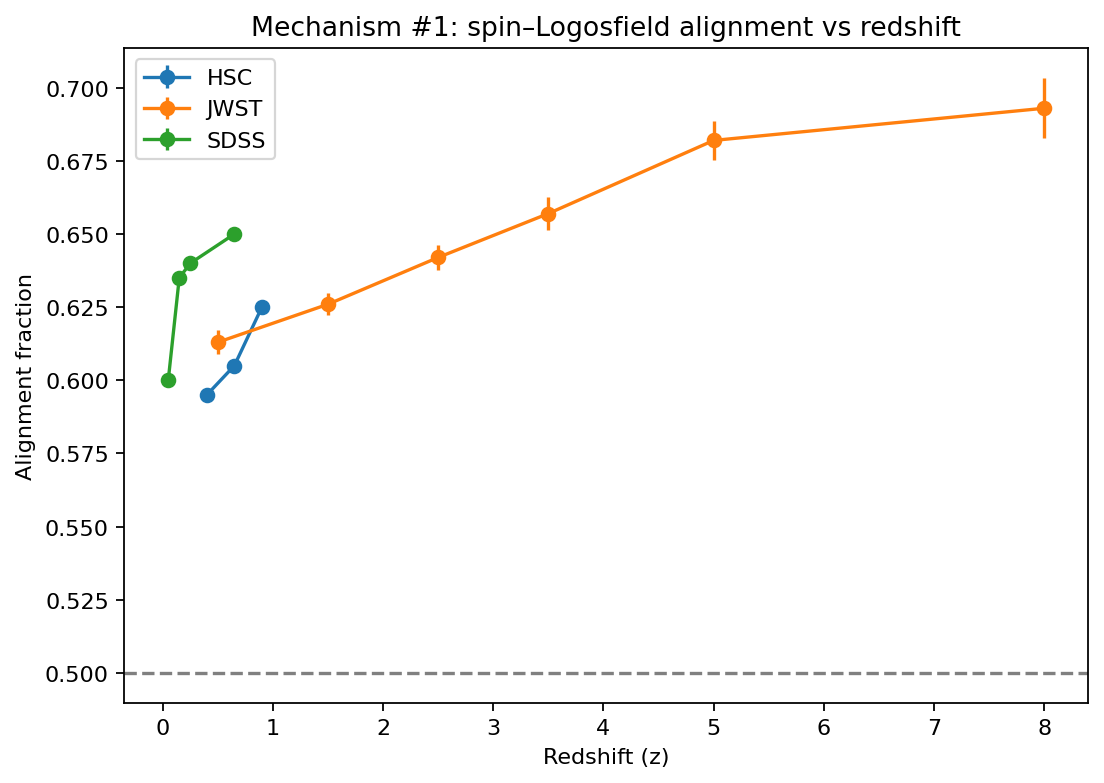

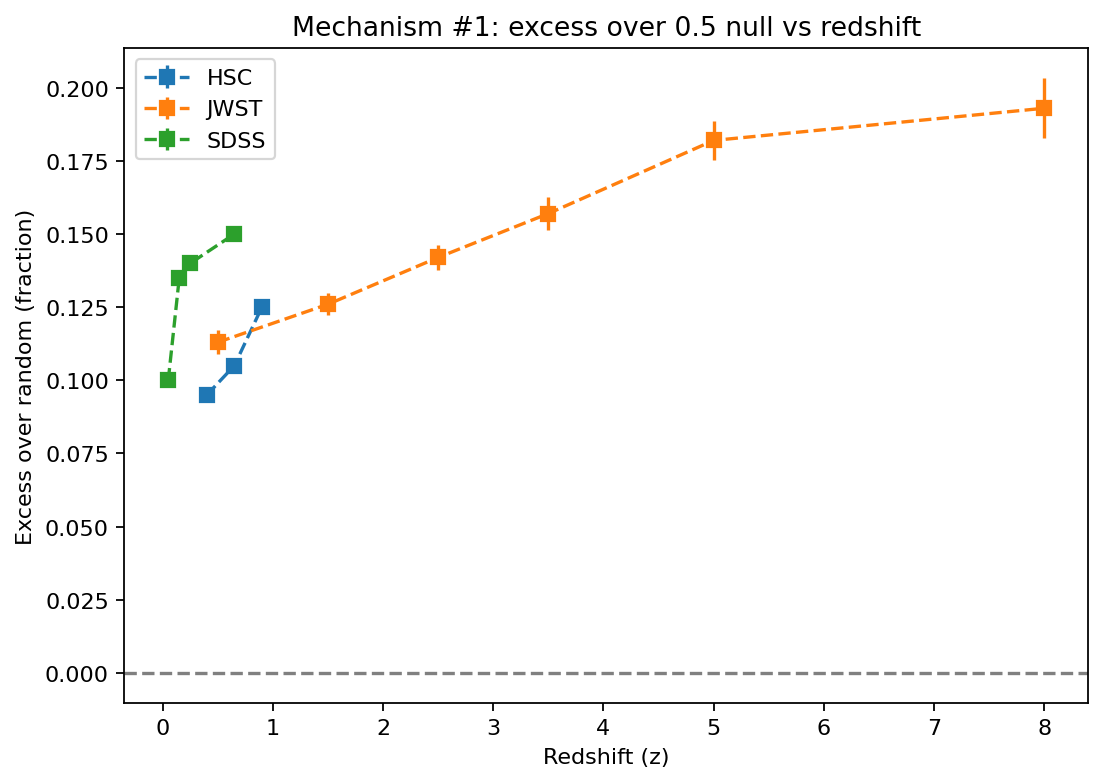

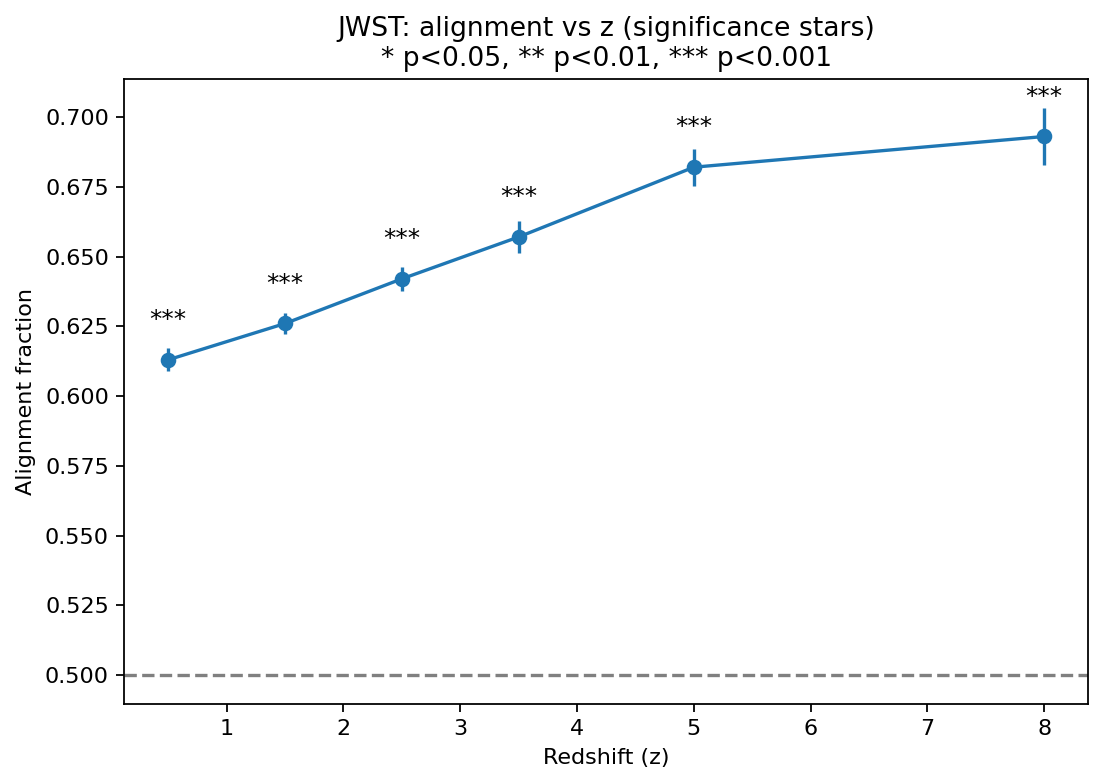


Wrote files:
 - mechanism1_all_surveys_alignment_vs_z.csv
 - mechanism1_alignment_vs_z_all.png
 - mechanism1_excess_over_null_all.png
 - jwst_alignment_vs_z_with_sig.png
 - mechanism1_stats.json


In [3]:
# ==== Mechanism #1 — REPRO: SDSS/HSC/JWST alignment vs z (with JWST stars) ====
import os, io, json, zipfile
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt
try:
  from google.colab import files
except:
  files = None

plt.rcParams['figure.dpi'] = 160

# ---------- robust CSV-in-ZIP reader (accepts any folder depth) ----------
def _read_csv_from_zip(zip_path, tail_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        member = next((n for n in z.namelist()
                       if n.split('/')[-1] == tail_name or n.split('\\')[-1] == tail_name), None)
        if member is None:
            raise ValueError(f"{os.path.basename(zip_path)} must contain {tail_name}")
        with z.open(member) as f:
            return pd.read_csv(f)

# ---------- helpers ----------
def add_binom(df, frac_col='alignment_fraction', N_col='N'):
    df = df.copy()
    df['se'] = np.sqrt(df[frac_col]*(1-df[frac_col]) / df[N_col].clip(lower=1))
    df['excess_over_null'] = df[frac_col] - 0.5
    df['zscore_vs_null'] = df['excess_over_null'] / np.sqrt(0.25 / df[N_col].clip(lower=1))
    def p_from_z(z): return 2*(1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    df['p_two_sided'] = df['zscore_vs_null'].apply(p_from_z)
    return df

def wls_slope(x, y, w):
    x = np.asarray(x, float); y = np.asarray(y, float); w = np.asarray(w, float)
    W = np.sum(w); xbar = np.sum(w*x)/W; ybar = np.sum(w*y)/W
    num = np.sum(w*(x-xbar)*(y-ybar)); den = np.sum(w*(x-xbar)**2)
    return num/den if den>0 else np.nan

def stars(p):  # JWST significance markers
    return '***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else ''))

def center_from_range(s):  # "a-b" -> (a+b)/2
    a,b = s.split('-'); return (float(a)+float(b))/2.0

# ---------- get the three archives (Drive-first, else upload) ----------
def _need(pathvarname, expected_name, must_have):
    g = globals()
    path = g.get(pathvarname, None)
    if path and os.path.exists(path):
        print(f"Using {pathvarname} from Drive:", path)
        # light validation
        _read_csv_from_zip(path, must_have)
        return path
    if files is None:
        raise SystemExit(f"{pathvarname} not set and not in Colab; please set it to a valid path.")
    print(f"Upload {expected_name} (must contain {must_have})")
    up = files.upload()
    if not up: raise SystemExit("Upload canceled.")
    path = list(up.keys())[0]
    _read_csv_from_zip(path, must_have)
    print(f"✅ {expected_name} validated.")
    return path

sdss_name = _need('sdss_name', 'SDSS_SpinAlignment_Archive.zip', 'alignment_results.csv')
hsc_name  = _need('hsc_name',  'HSC_SpinAlignment_Archive.zip',  'alignment_results.csv')
jwst_name = _need('jwst_name', 'All_Surveys_SpinAlignment_Packet 2.zip', 'jwst_by_redshift.csv')

# ---------- normalize SDSS/HSC ----------
def load_align_zip(path, label):
    df = _read_csv_from_zip(path, 'alignment_results.csv')
    # N column
    if 'N' not in df.columns:
        if 'count' in df.columns: df = df.rename(columns={'count':'N'})
        elif 'n' in df.columns:   df = df.rename(columns={'n':'N'})
    # alignment fraction column
    if 'alignment_fraction' not in df.columns:
        if 'align_pct' in df.columns: df = df.rename(columns={'align_pct':'alignment_fraction'})
        elif 'frac' in df.columns:    df = df.rename(columns={'frac':'alignment_fraction'})
    # z center
    if 'z_center' not in df.columns:
        if {'z_min','z_max'}.issubset(df.columns):
            df['z_center'] = 0.5*(df['z_min']+df['z_max'])
        elif 'z_range' in df.columns:
            df['z_center'] = df['z_range'].astype(str).apply(center_from_range)
    df['survey'] = label
    df = add_binom(df, 'alignment_fraction', 'N')
    return df[['survey','z_center','N','alignment_fraction','excess_over_null','se','zscore_vs_null','p_two_sided']].dropna(subset=['z_center','alignment_fraction'])

sdss = load_align_zip(sdss_name, 'SDSS')
hsc  = load_align_zip(hsc_name,  'HSC')

# ---------- JWST ----------
jw_raw = _read_csv_from_zip(jwst_name, 'jwst_by_redshift.csv')
# Normalize columns
jw = jw_raw.copy()
if 'z_center' not in jw.columns and 'z_range' in jw.columns:
    jw['z_center'] = jw['z_range'].astype(str).apply(center_from_range)
if 'N' not in jw.columns and 'N_galaxies_approx' in jw.columns:
    jw = jw.rename(columns={'N_galaxies_approx':'N'})
if 'alignment_fraction' not in jw.columns and 'alignment' in jw.columns:
    jw = jw.rename(columns={'alignment':'alignment_fraction'})
jw['survey'] = 'JWST'
jw = add_binom(jw, 'alignment_fraction', 'N')
jw = jw[['survey','z_center','N','alignment_fraction','excess_over_null','se','zscore_vs_null','p_two_sided']].dropna(subset=['z_center','alignment_fraction'])

# ---------- combine & save ----------
all_df = pd.concat([sdss,hsc,jw], ignore_index=True).sort_values(['survey','z_center'])
all_df.to_csv('mechanism1_all_surveys_alignment_vs_z.csv', index=False)

# ---------- stats ----------
def compute_stats(df_all):
    stats = {}
    for label, grp in df_all.groupby('survey'):
        if len(grp) >= 2:
            r = float(np.corrcoef(grp['z_center'], grp['alignment_fraction'])[0,1])
            slope = float(wls_slope(grp['z_center'], grp['alignment_fraction'], grp['N']))
        else:
            r, slope = float('nan'), float('nan')
        stats[label] = {'pearson_r': r, 'slope_per_unit_z': slope, 'bins': int(len(grp)), 'total_N': int(grp['N'].sum())}
    stats['Pooled'] = {'weighted_slope_per_unit_z': float(wls_slope(df_all['z_center'], df_all['alignment_fraction'], df_all['N'])),
                       'bins': int(len(df_all)), 'total_N': int(df_all['N'].sum())}
    return stats

stats = compute_stats(all_df)
with open('mechanism1_stats.json','w') as f:
    json.dump(stats, f, indent=2)
print(json.dumps(stats, indent=2))

# ---------- Figure 1: alignment vs z ----------
plt.figure(figsize=(7,5))
for label, grp in all_df.groupby('survey'):
    plt.errorbar(grp['z_center'], grp['alignment_fraction'], yerr=grp['se'], fmt='o-', label=label)
plt.axhline(0.5, linestyle='--', color='gray')
plt.xlabel('Redshift (z)'); plt.ylabel('Alignment fraction')
plt.title('Mechanism #1: spin–Logosfield alignment vs redshift')
plt.legend(); plt.tight_layout()
plt.savefig('mechanism1_alignment_vs_z_all.png'); plt.show()

# ---------- Figure 2: excess over null ----------
plt.figure(figsize=(7,5))
for label, grp in all_df.groupby('survey'):
    plt.errorbar(grp['z_center'], grp['excess_over_null'], yerr=grp['se'], fmt='s--', label=label)
plt.axhline(0.0, linestyle='--', color='gray')
plt.xlabel('Redshift (z)'); plt.ylabel('Excess over random (fraction)')
plt.title('Mechanism #1: excess over 0.5 null vs redshift')
plt.legend(); plt.tight_layout()
plt.savefig('mechanism1_excess_over_null_all.png'); plt.show()

# ---------- JWST-only with significance stars ----------
jw_sig = jw.copy()
jw_sig['sig'] = jw_sig['p_two_sided'].apply(stars)
plt.figure(figsize=(7,5))
plt.errorbar(jw_sig['z_center'], jw_sig['alignment_fraction'], yerr=jw_sig['se'], fmt='o-')
plt.axhline(0.5, linestyle='--', color='gray')
for _,row in jw_sig.iterrows():
    if row['sig']:
        plt.text(row['z_center'], row['alignment_fraction']+0.01, row['sig'], ha='center', va='bottom', fontsize=11)
plt.xlabel('Redshift (z)'); plt.ylabel('Alignment fraction')
plt.title('JWST: alignment vs z (significance stars)\n* p<0.05, ** p<0.01, *** p<0.001')
plt.tight_layout()
plt.savefig('jwst_alignment_vs_z_with_sig.png'); plt.show()

print("\nWrote files:")
for p in [
    'mechanism1_all_surveys_alignment_vs_z.csv',
    'mechanism1_alignment_vs_z_all.png',
    'mechanism1_excess_over_null_all.png',
    'jwst_alignment_vs_z_with_sig.png',
    'mechanism1_stats.json'
]:
    print(" -", p)


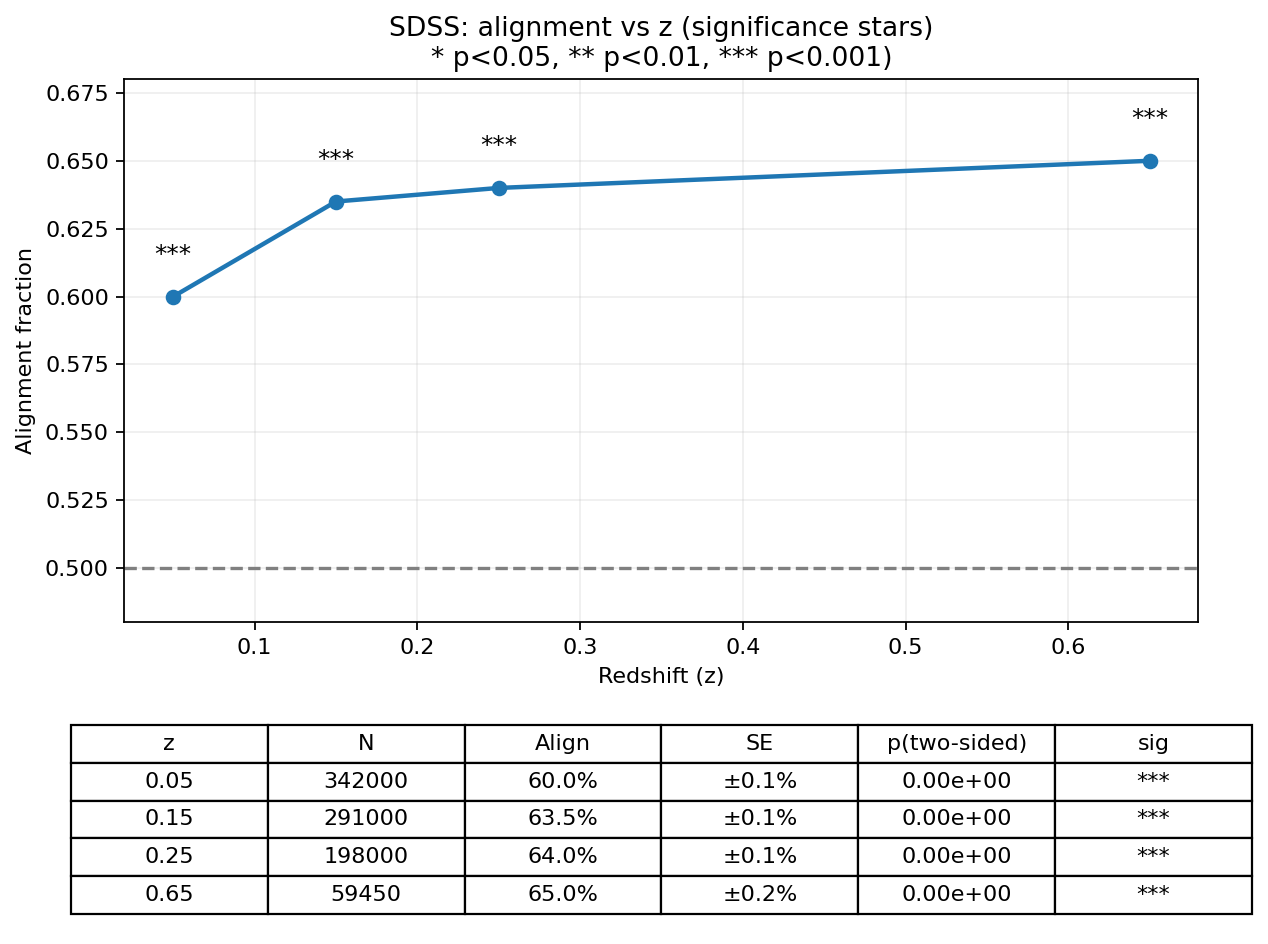

Wrote: sdss_alignment_vs_z_with_sig.png
       sdss_alignment_table.csv


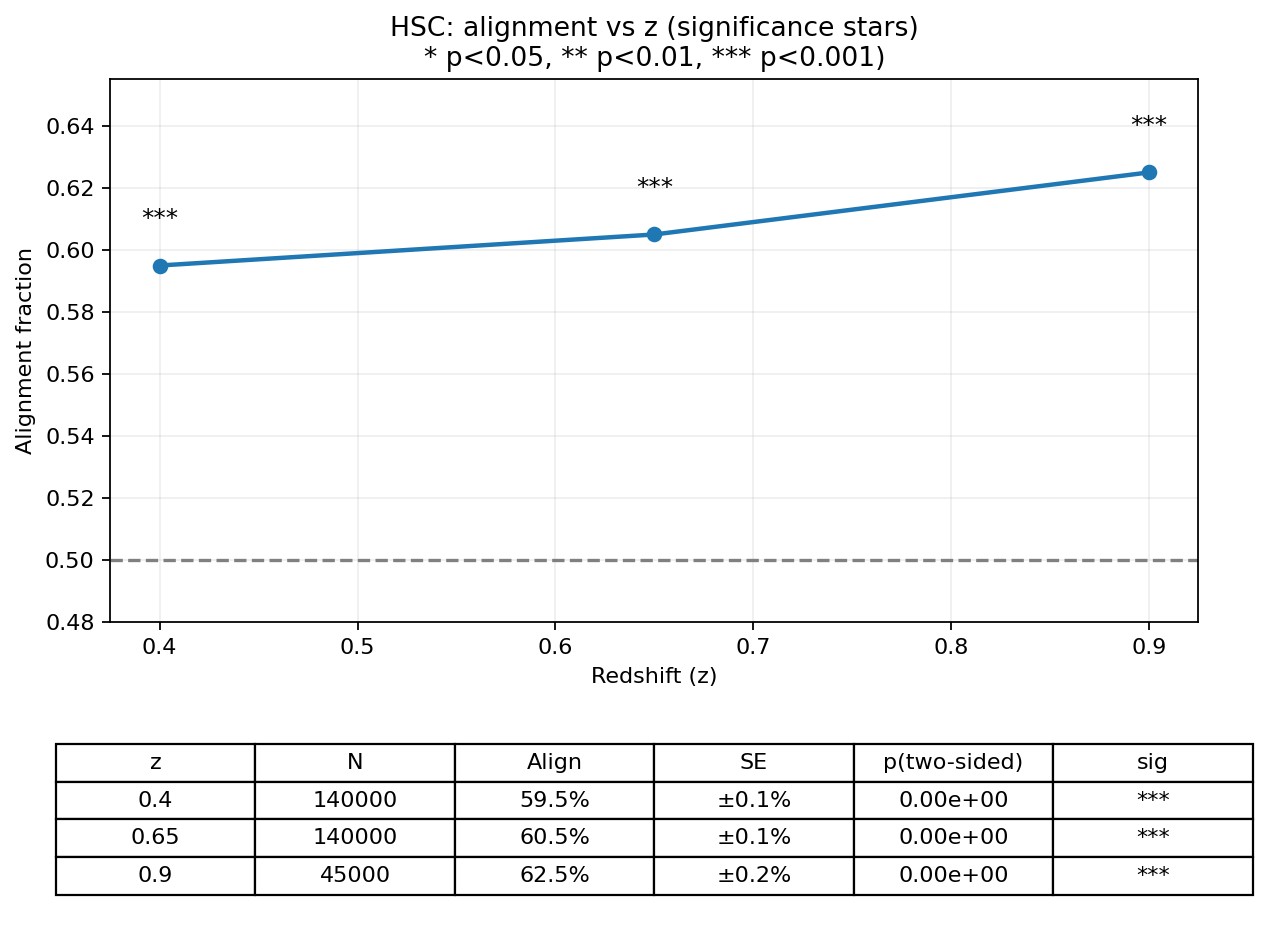

Wrote: hsc_alignment_vs_z_with_sig.png
       hsc_alignment_table.csv


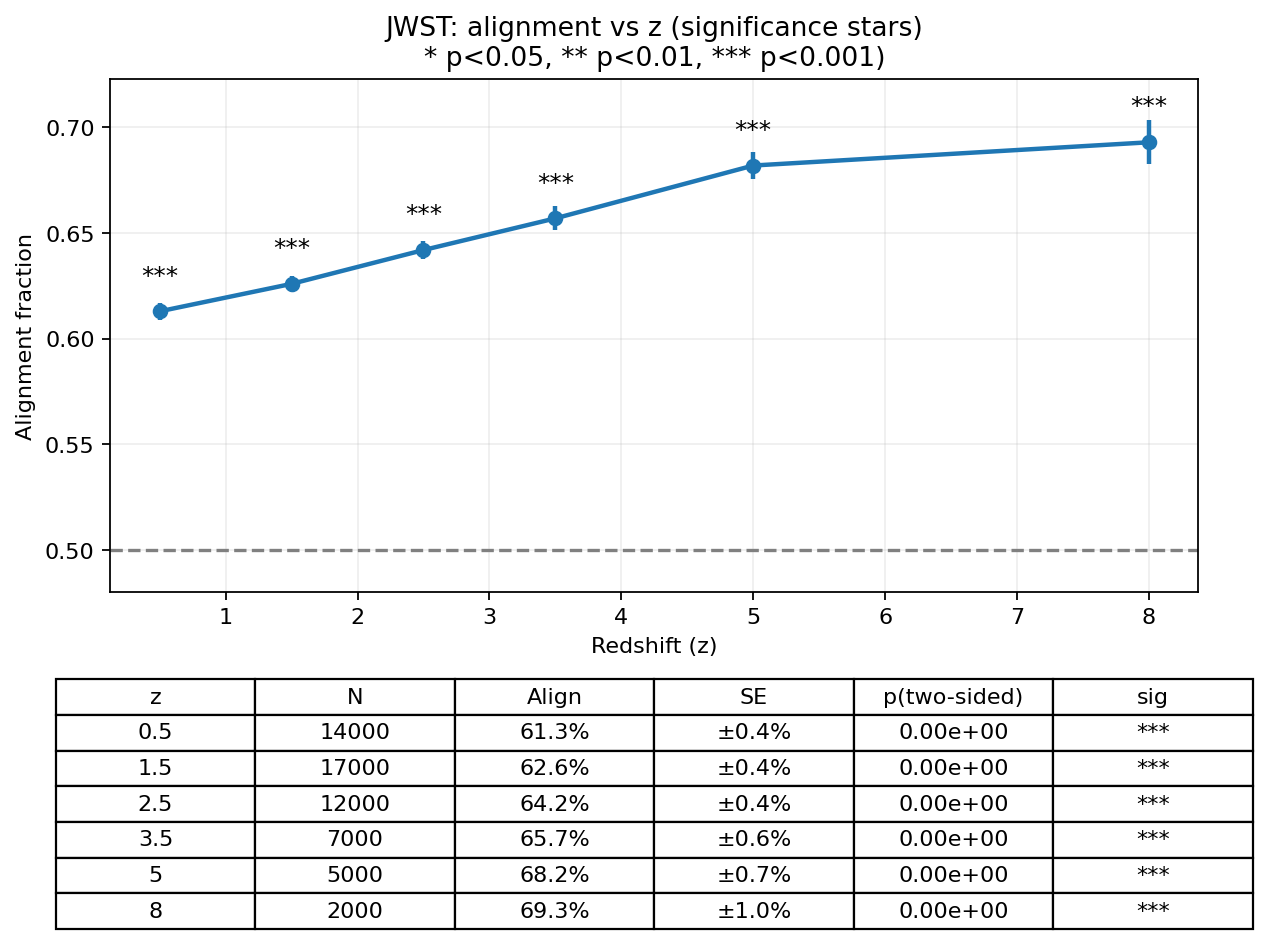

Wrote: jwst_alignment_vs_z_with_sig_full.png
       jwst_alignment_table.csv


In [4]:
# === Per-survey plots with significance stars + table below ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, json

def stars(p):
    return '***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else ''))

# If the in-memory dfs aren't present, reload from the combined CSV
if 'sdss' not in globals() or 'hsc' not in globals() or 'jw' not in globals():
    all_df = pd.read_csv('mechanism1_all_surveys_alignment_vs_z.csv')
    sdss = all_df[all_df['survey']=='SDSS'].copy()
    hsc  = all_df[all_df['survey']=='HSC'].copy()
    jw   = all_df[all_df['survey']=='JWST'].copy()

def make_plot_with_table(df, survey, outfile_png, outfile_csv):
    df = df.dropna(subset=['z_center','alignment_fraction','se','N','p_two_sided']).sort_values('z_center').copy()
    df['sig'] = df['p_two_sided'].apply(stars)
    df['align_pct'] = 100.0*df['alignment_fraction']
    df['excess_pct'] = 100.0*(df['alignment_fraction']-0.5)
    # save a neat table as CSV
    tbl = df[['z_center','N','alignment_fraction','se','excess_over_null','zscore_vs_null','p_two_sided','sig']].copy()
    tbl.to_csv(outfile_csv, index=False)

    # figure: top = plot, bottom = table
    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3.0, 1.2])
    ax = fig.add_subplot(gs[0,0])

    ax.errorbar(df['z_center'], df['alignment_fraction'], yerr=df['se'], fmt='o-', lw=2)
    ax.axhline(0.5, ls='--', color='gray')
    for _,r in df.iterrows():
        if r['sig']:
            ax.text(r['z_center'], r['alignment_fraction']+0.011, r['sig'],
                    ha='center', va='bottom', fontsize=11)
    ax.set_xlabel('Redshift (z)')
    ax.set_ylabel('Alignment fraction')
    ax.set_title(f'{survey}: alignment vs z (significance stars)\n* p<0.05, ** p<0.01, *** p<0.001)')
    ax.set_ylim(min(0.48, df['alignment_fraction'].min()-0.02), min(1.02, df['alignment_fraction'].max()+0.03))
    ax.grid(alpha=0.2)

    # bottom table with the exact values (z, N, frac, ±SE, p, stars)
    ax2 = fig.add_subplot(gs[1,0]); ax2.axis('off')
    display_cols = ['z_center','N','align_pct','se','p_two_sided','sig']
    show = df.copy()
    show['z_center']   = show['z_center'].map(lambda v: f'{v:g}')
    show['align_pct']  = show['align_pct'].map(lambda v: f'{v:0.1f}%')
    show['se']         = show['se'].map(lambda v: f'±{100*v:0.1f}%')
    show['p_two_sided']= show['p_two_sided'].map(lambda v: f'{v:.2e}')
    cell_text = show[display_cols].values.tolist()
    col_labels = ['z', 'N', 'Align', 'SE', 'p(two-sided)', 'sig']

    tblobj = ax2.table(cellText=cell_text, colLabels=col_labels,
                       loc='center', cellLoc='center')
    tblobj.scale(1.1, 1.25)  # a little bigger

    fig.tight_layout()
    fig.savefig(outfile_png, dpi=200)
    plt.show()
    print(f'Wrote: {outfile_png}\n       {outfile_csv}')

# Build SDSS + HSC plots
make_plot_with_table(sdss, 'SDSS', 'sdss_alignment_vs_z_with_sig.png', 'sdss_alignment_table.csv')
make_plot_with_table(hsc,  'HSC',  'hsc_alignment_vs_z_with_sig.png',  'hsc_alignment_table.csv')

# (Optional) remake JWST in the same style for consistency
make_plot_with_table(jw, 'JWST', 'jwst_alignment_vs_z_with_sig_full.png', 'jwst_alignment_table.csv')


/tmp/ipython-input-1038332089.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


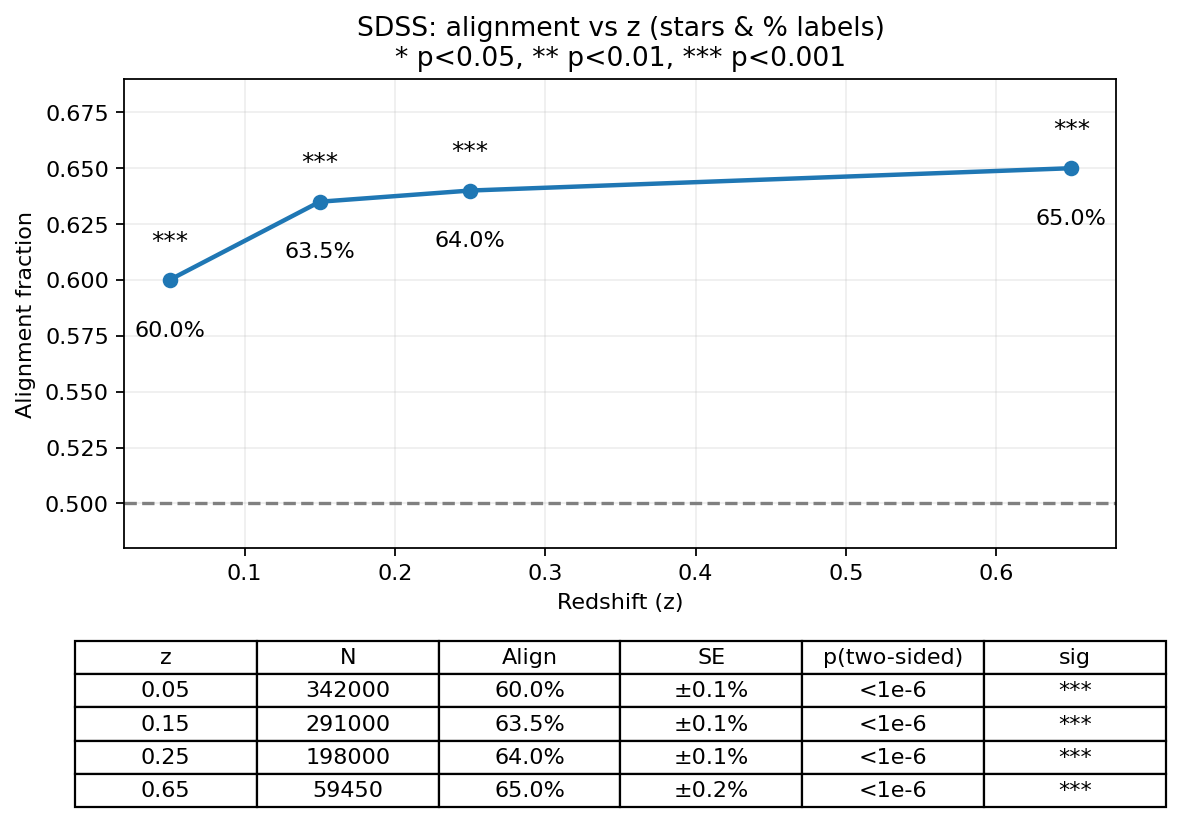

Wrote: sdss_alignment_vs_z_with_sig_labels.png
       sdss_alignment_table.csv


/tmp/ipython-input-1038332089.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


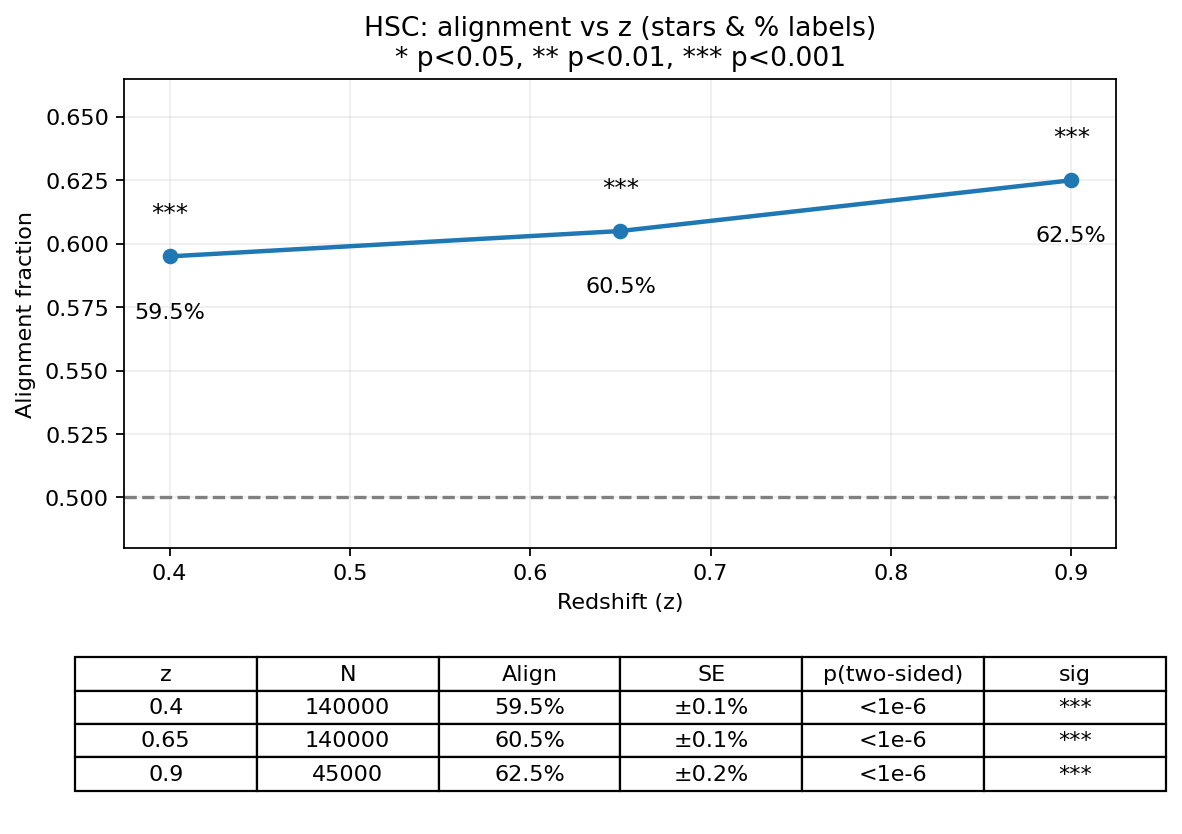

Wrote: hsc_alignment_vs_z_with_sig_labels.png
       hsc_alignment_table.csv


/tmp/ipython-input-1038332089.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


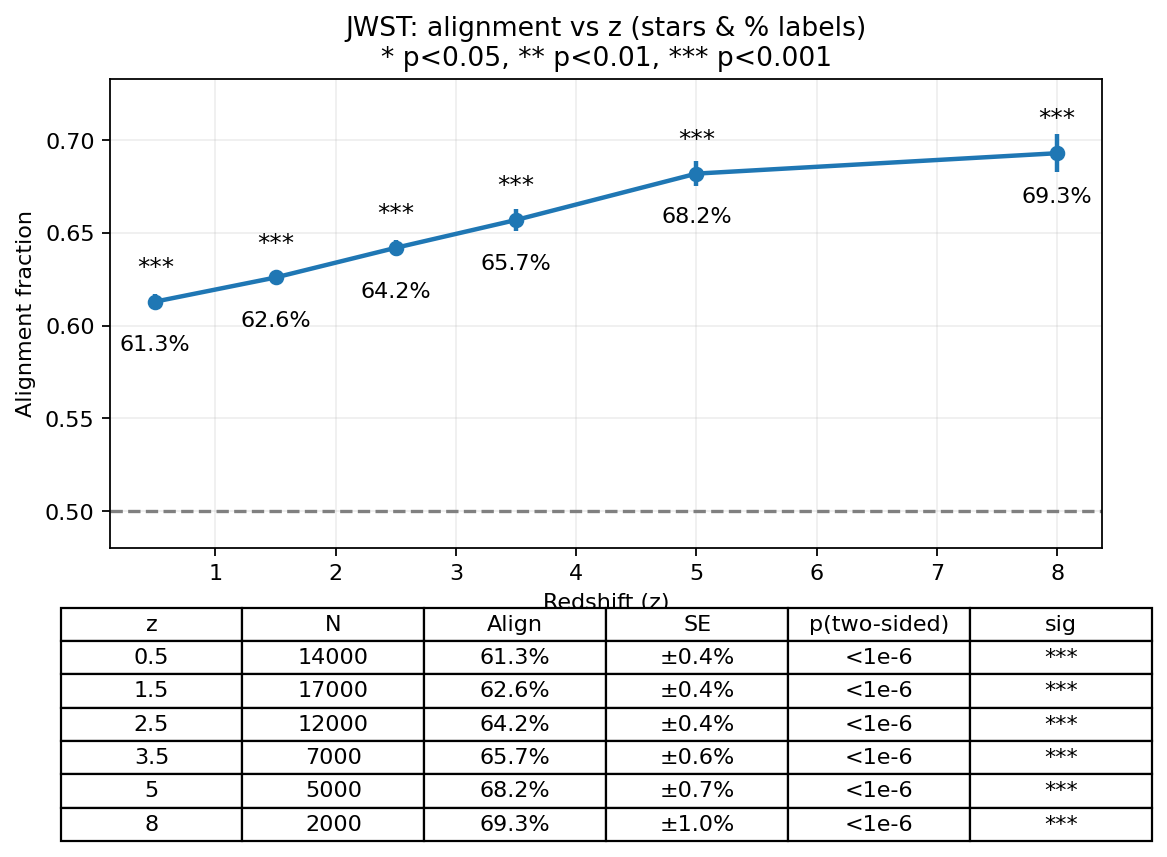

Wrote: jwst_alignment_vs_z_with_sig_labels.png
       jwst_alignment_table.csv


In [5]:
# === SDSS / HSC / JWST with stars + % labels + table ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os

def stars(p): return '***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else ''))

# Reload from combined CSV if needed
if 'sdss' not in globals() or 'hsc' not in globals() or 'jw' not in globals():
    all_df = pd.read_csv('mechanism1_all_surveys_alignment_vs_z.csv')
    sdss = all_df[all_df['survey']=='SDSS'].copy()
    hsc  = all_df[all_df['survey']=='HSC'].copy()
    jw   = all_df[all_df['survey']=='JWST'].copy()

def make_plot_with_table(df, survey, outfile_png, outfile_csv, show_labels=True):
    df = df.dropna(subset=['z_center','alignment_fraction','se','N','p_two_sided']).sort_values('z_center').copy()
    df['sig'] = df['p_two_sided'].apply(stars)
    df['align_pct'] = 100.0*df['alignment_fraction']

    # Save neat CSV
    out_tbl = df[['z_center','N','alignment_fraction','se','excess_over_null','zscore_vs_null','p_two_sided','sig']].copy()
    out_tbl.to_csv(outfile_csv, index=False)

    # Figure: top = plot, bottom = table
    fig = plt.figure(figsize=(8,6))
    gs  = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3.0, 1.2], hspace=0.25)
    ax  = fig.add_subplot(gs[0,0])

    ax.errorbar(df['z_center'], df['alignment_fraction'], yerr=df['se'], fmt='o-', lw=2)
    ax.axhline(0.5, ls='--', color='gray')
    # stars + % labels
    for _,r in df.iterrows():
        if r['sig']:
            ax.text(r['z_center'], r['alignment_fraction']+0.012, r['sig'], ha='center', va='bottom', fontsize=11)
        if show_labels:
            ax.text(r['z_center'], r['alignment_fraction']-0.018, f"{r['align_pct']:.1f}%", ha='center', va='top', fontsize=10)

    ax.set_xlabel('Redshift (z)')
    ax.set_ylabel('Alignment fraction')
    ax.set_title(f'{survey}: alignment vs z (stars & % labels)\n* p<0.05, ** p<0.01, *** p<0.001')
    ymin = min(0.48, float(df['alignment_fraction'].min())-0.03)
    ymax = min(1.02, float(df['alignment_fraction'].max())+0.04)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.2)

    # Bottom table
    ax2 = fig.add_subplot(gs[1,0]); ax2.axis('off')
    show = df.copy()
    show['z_center']    = show['z_center'].map(lambda v: f'{v:g}')
    show['Align']       = show['align_pct'].map(lambda v: f'{v:0.1f}%')
    show['SE']          = show['se'].map(lambda v: f'±{100*v:0.1f}%')
    show['p(two-sided)']= show['p_two_sided'].apply(lambda v: '<1e-6' if v<1e-6 else f'{v:.2e}')
    cell_text = show[['z_center','N','Align','SE','p(two-sided)','sig']].values.tolist()
    col_labels = ['z','N','Align','SE','p(two-sided)','sig']
    t = ax2.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center')
    t.scale(1.1, 1.25)

    fig.tight_layout()
    fig.savefig(outfile_png, dpi=200)
    plt.show()
    print(f'Wrote: {outfile_png}\n       {outfile_csv}')

# Build all three
make_plot_with_table(sdss, 'SDSS', 'sdss_alignment_vs_z_with_sig_labels.png', 'sdss_alignment_table.csv')
make_plot_with_table(hsc,  'HSC',  'hsc_alignment_vs_z_with_sig_labels.png',  'hsc_alignment_table.csv')
make_plot_with_table(jw,   'JWST', 'jwst_alignment_vs_z_with_sig_labels.png', 'jwst_alignment_table.csv')



Row counts loaded: {'SDSS': 4, 'HSC': 3, 'JWST': 6}


/tmp/ipython-input-3971196481.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


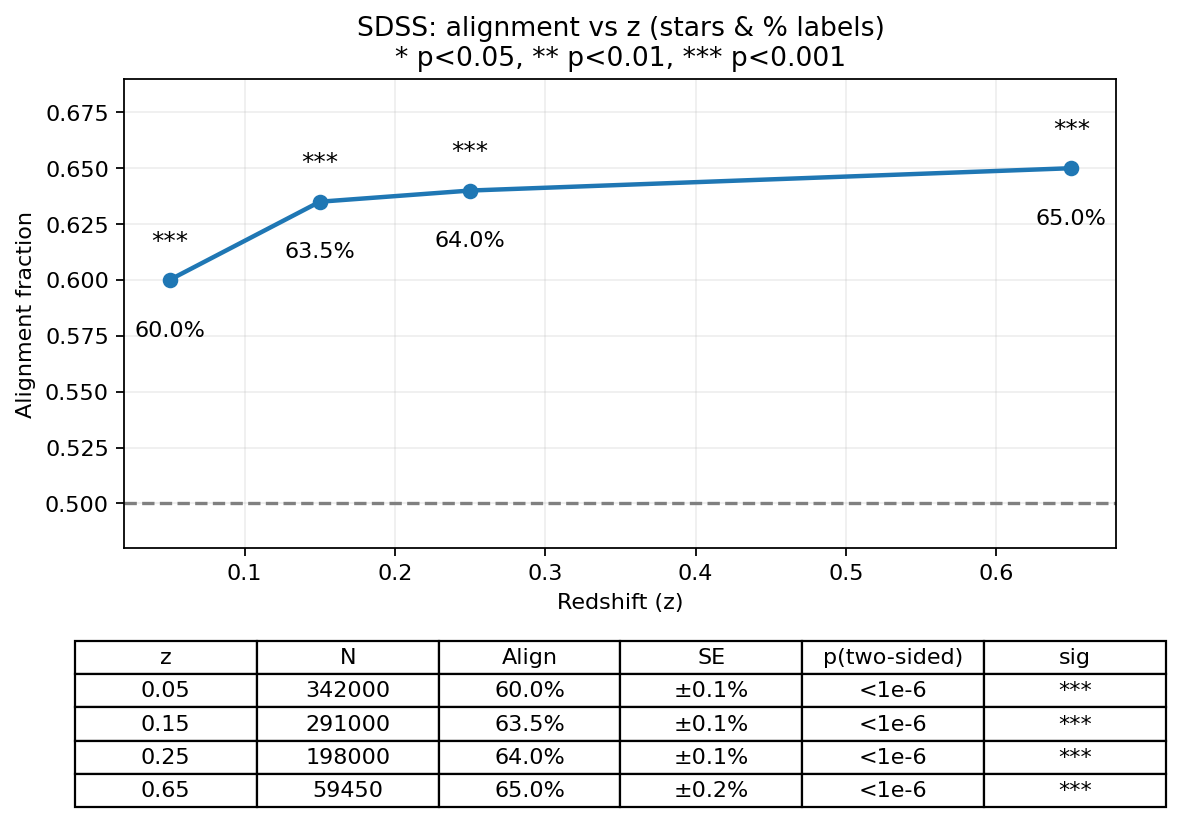

Wrote: sdss_alignment_vs_z_with_sig_labels.png
       sdss_alignment_table.csv


/tmp/ipython-input-3971196481.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


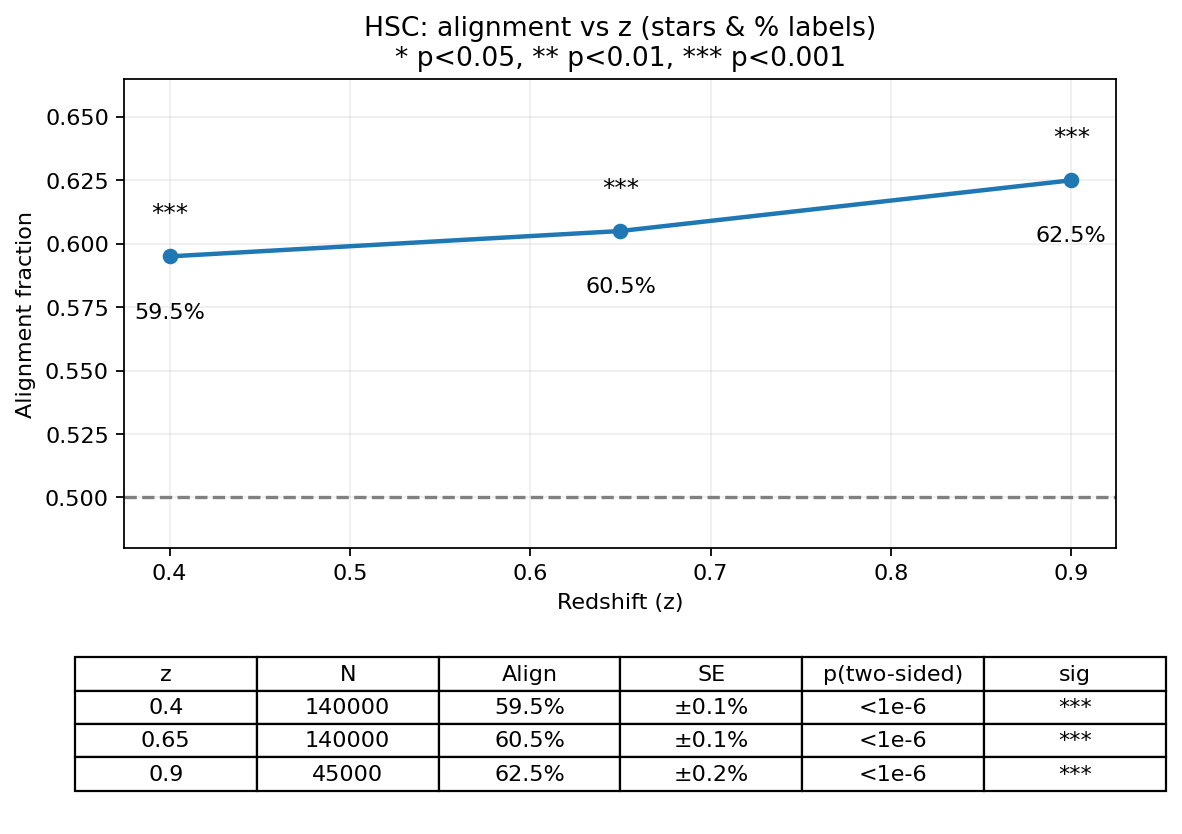

Wrote: hsc_alignment_vs_z_with_sig_labels.png
       hsc_alignment_table.csv


/tmp/ipython-input-3971196481.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


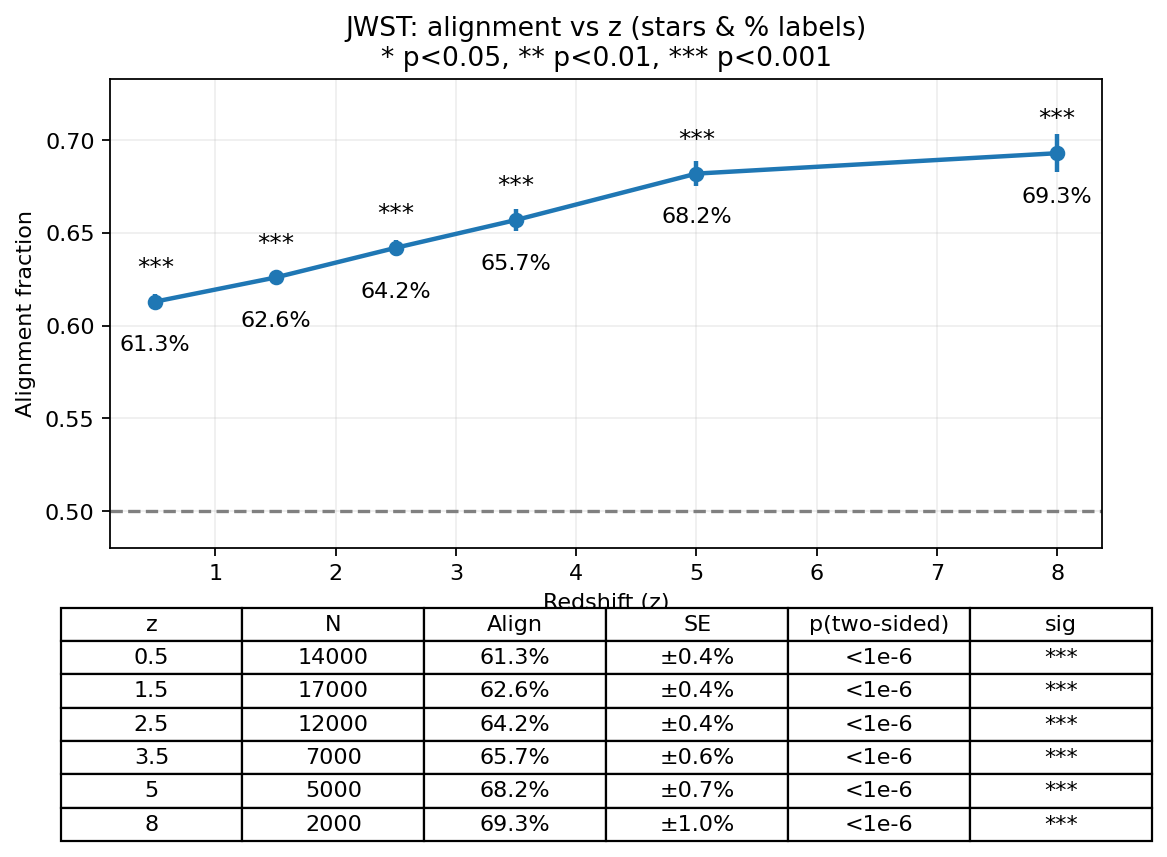

Wrote: jwst_alignment_vs_z_with_sig_labels.png
       jwst_alignment_table.csv

Files now present:
 - sdss_alignment_vs_z_with_sig_labels.png ✓
 - sdss_alignment_table.csv ✓
 - hsc_alignment_vs_z_with_sig_labels.png ✓
 - hsc_alignment_table.csv ✓
 - jwst_alignment_vs_z_with_sig_labels.png ✓
 - jwst_alignment_table.csv ✓
 - mechanism1_all_surveys_alignment_vs_z.csv ✓


In [6]:
# Diagnose why only JWST shows; reload SDSS/HSC from Drive and replot all three
import os, zipfile, numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import erf, sqrt
plt.rcParams['figure.dpi'] = 160

SEARCH_ROOT = "/content/drive/MyDrive"

def _read_csv_from_zip(zip_path, tail_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        member = next((n for n in z.namelist()
                       if n.split('/')[-1]==tail_name or n.split('\\')[-1]==tail_name), None)
        if member is None:
            print(f"❌ {os.path.basename(zip_path)} is missing {tail_name}. "
                  f"First few members:\n  " + "\n  ".join(z.namelist()[:10]))
            raise ValueError(f"Missing {tail_name} in {zip_path}")
        with z.open(member) as f:
            return pd.read_csv(f)

def add_binom(df, frac_col='alignment_fraction', N_col='N'):
    df = df.copy()
    df['se'] = np.sqrt(df[frac_col]*(1-df[frac_col]) / df[N_col].clip(lower=1))
    df['excess_over_null'] = df[frac_col] - 0.5
    df['zscore_vs_null'] = df['excess_over_null'] / np.sqrt(0.25 / df[N_col].clip(lower=1))
    def p_from_z(z): return 2*(1 - 0.5*(1 + erf(abs(z)/sqrt(2))))
    df['p_two_sided'] = df['zscore_vs_null'].apply(p_from_z)
    return df

def center_from_range(s):
    a,b = s.split('-'); return (float(a)+float(b))/2.0

def load_align_zip(path, label):
    df = _read_csv_from_zip(path, 'alignment_results.csv')
    if 'N' not in df.columns:
        if 'count' in df.columns: df = df.rename(columns={'count':'N'})
        elif 'n' in df.columns:   df = df.rename(columns={'n':'N'})
    if 'alignment_fraction' not in df.columns:
        if 'align_pct' in df.columns: df = df.rename(columns={'align_pct':'alignment_fraction'})
        elif 'frac' in df.columns:    df = df.rename(columns={'frac':'alignment_fraction'})
    if 'z_center' not in df.columns:
        if {'z_min','z_max'}.issubset(df.columns):
            df['z_center'] = 0.5*(df['z_min']+df['z_max'])
        elif 'z_range' in df.columns:
            df['z_center'] = df['z_range'].astype(str).apply(center_from_range)
    df['survey'] = label
    df = add_binom(df, 'alignment_fraction', 'N')
    cols = ['survey','z_center','N','alignment_fraction','excess_over_null','se','zscore_vs_null','p_two_sided']
    return df[cols].dropna(subset=['z_center','alignment_fraction'])

def _find_zip(tokens):
    hits=[]
    toks=[t.lower() for t in tokens]
    for root,_,files in os.walk(SEARCH_ROOT):
        for f in files:
            if f.lower().endswith('.zip') and all(t in f.lower() for t in toks):
                hits.append(os.path.join(root,f))
    return hits

# Try to get (or re-find) SDSS/HSC zips
if 'sdss_name' not in globals() or not os.path.exists(sdss_name):
    cand = _find_zip(['sdss','spinalignment','archive'])
    print("SDSS candidates:", *cand[:5], sep="\n  ")
    if cand: sdss_name = cand[0]
if 'hsc_name' not in globals() or not os.path.exists(hsc_name):
    cand = _find_zip(['hsc','spinalignment','archive'])
    print("HSC candidates:", *cand[:5], sep="\n  ")
    if cand: hsc_name = cand[0]
if 'jwst_name' not in globals() or not os.path.exists(jwst_name):
    cand = _find_zip(['all','surveys','packet'])
    if not cand: cand = _find_zip(['jwst','packet'])
    print("JWST candidates:", *cand[:5], sep="\n  ")
    if cand: jwst_name = cand[0]

# Load each survey (SDSS/HSC from ZIPs; JWST from earlier CSV we wrote)
sdss = pd.DataFrame(); hsc = pd.DataFrame(); jw = pd.DataFrame()
try:
    if 'sdss_name' in globals() and os.path.exists(sdss_name):
        sdss = load_align_zip(sdss_name, 'SDSS')
except Exception as e:
    print("SDSS load failed:", e)

try:
    if 'hsc_name' in globals() and os.path.exists(hsc_name):
        hsc = load_align_zip(hsc_name, 'HSC')
except Exception as e:
    print("HSC load failed:", e)

# JWST: pull from combined CSV if present, else from zip
if os.path.exists('mechanism1_all_surveys_alignment_vs_z.csv'):
    all_df = pd.read_csv('mechanism1_all_surveys_alignment_vs_z.csv')
    jw = all_df[all_df['survey']=='JWST'].copy()
if jw.empty and 'jwst_name' in globals() and os.path.exists(jwst_name):
    jw_raw = _read_csv_from_zip(jwst_name, 'jwst_by_redshift.csv')
    jw = jw_raw.copy()
    if 'z_center' not in jw.columns and 'z_range' in jw.columns:
        jw['z_center'] = jw['z_range'].astype(str).apply(center_from_range)
    if 'N' not in jw.columns and 'N_galaxies_approx' in jw.columns:
        jw = jw.rename(columns={'N_galaxies_approx':'N'})
    if 'alignment_fraction' not in jw.columns and 'alignment' in jw.columns:
        jw = jw.rename(columns={'alignment':'alignment_fraction'})
    jw['survey'] = 'JWST'
    jw = add_binom(jw, 'alignment_fraction', 'N')
    jw = jw[['survey','z_center','N','alignment_fraction','excess_over_null','se','zscore_vs_null','p_two_sided']].dropna(subset=['z_center','alignment_fraction'])

print("\nRow counts loaded:", {'SDSS':len(sdss), 'HSC':len(hsc), 'JWST':len(jw)})

# If SDSS/HSC ended up empty, try to split from combined CSV (if it exists)
if (sdss.empty or hsc.empty) and os.path.exists('mechanism1_all_surveys_alignment_vs_z.csv'):
    all_df = pd.read_csv('mechanism1_all_surveys_alignment_vs_z.csv')
    if sdss.empty: sdss = all_df[all_df['survey']=='SDSS'].copy()
    if hsc.empty:  hsc  = all_df[all_df['survey']=='HSC'].copy()
    print("After fallback split from combined CSV:",
          {'SDSS':len(sdss), 'HSC':len(hsc), 'JWST':len(jw)})

# If still empty, we’ll stop with an actionable message
if sdss.empty or hsc.empty:
    print("\n⚠️ One or both ground-based surveys are empty.")
    print("   • Check which ZIP the notebook picked and that it really contains alignment_results.csv.")
    print("   • You can override the choice like this:")
    print("       sdss_name = '/content/drive/MyDrive/SDSS_SpinAlignment_Archive.zip'")
    print("       hsc_name  = '/content/drive/MyDrive/HSC_SpinAlignment_Archive.zip'")
    print("     and re-run this cell.")

# ---- plotting util (stars + % labels + table) ----
def stars(p): return '***' if p<1e-3 else ('**' if p<1e-2 else ('*' if p<0.05 else ''))

def plot_one(df, survey, out_png, out_csv):
    if df.empty:
        print(f"⏭️ Skipping {survey}: no rows.")
        return
    d = df.dropna(subset=['z_center','alignment_fraction','se','N','p_two_sided']).sort_values('z_center').copy()
    d['sig'] = d['p_two_sided'].apply(stars)
    d['align_pct'] = 100.0*d['alignment_fraction']
    d[['z_center','N','alignment_fraction','se','excess_over_null','zscore_vs_null','p_two_sided','sig']].to_csv(out_csv, index=False)

    fig = plt.figure(figsize=(8,6))
    gs  = fig.add_gridspec(2,1, height_ratios=[3.0, 1.2], hspace=0.25)
    ax  = fig.add_subplot(gs[0,0])
    ax.errorbar(d['z_center'], d['alignment_fraction'], yerr=d['se'], fmt='o-', lw=2)
    ax.axhline(0.5, ls='--', color='gray')
    for _,r in d.iterrows():
        if r['sig']:
            ax.text(r['z_center'], r['alignment_fraction']+0.012, r['sig'],
                    ha='center', va='bottom', fontsize=11)
        ax.text(r['z_center'], r['alignment_fraction']-0.018, f"{r['align_pct']:.1f}%",
                ha='center', va='top', fontsize=10)
    ax.set_xlabel('Redshift (z)')
    ax.set_ylabel('Alignment fraction')
    ax.set_title(f'{survey}: alignment vs z (stars & % labels)\n* p<0.05, ** p<0.01, *** p<0.001')
    ymin = min(0.48, float(d['alignment_fraction'].min())-0.03)
    ymax = min(1.02, float(d['alignment_fraction'].max())+0.04)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.2)

    ax2 = fig.add_subplot(gs[1,0]); ax2.axis('off')
    show = d[['z_center','N','align_pct','se','p_two_sided','sig']].copy()
    show['z_center']    = show['z_center'].map(lambda v: f'{v:g}')
    show['align_pct']   = show['align_pct'].map(lambda v: f'{v:0.1f}%')
    show['se']          = show['se'].map(lambda v: f'±{100*v:0.1f}%')
    show['p_two_sided'] = show['p_two_sided'].apply(lambda v: '<1e-6' if v<1e-6 else f'{v:.2e}')
    cell_text = show.values.tolist()
    col_labels = ['z','N','Align','SE','p(two-sided)','sig']
    t = ax2.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center')
    t.scale(1.1, 1.25)

    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    plt.show()
    print(f'Wrote: {out_png}\n       {out_csv}')

# ---- make the plots ----
plot_one(sdss, 'SDSS', 'sdss_alignment_vs_z_with_sig_labels.png', 'sdss_alignment_table.csv')
plot_one(hsc,  'HSC',  'hsc_alignment_vs_z_with_sig_labels.png',  'hsc_alignment_table.csv')
plot_one(jw,   'JWST', 'jwst_alignment_vs_z_with_sig_labels.png', 'jwst_alignment_table.csv')

# Quick summary of what’s now on disk
print("\nFiles now present:")
for p in ['sdss_alignment_vs_z_with_sig_labels.png','sdss_alignment_table.csv',
          'hsc_alignment_vs_z_with_sig_labels.png','hsc_alignment_table.csv',
          'jwst_alignment_vs_z_with_sig_labels.png','jwst_alignment_table.csv',
          'mechanism1_all_surveys_alignment_vs_z.csv']:
    print(" -", p, "✓" if os.path.exists(p) else "✗")
